<a href="https://colab.research.google.com/github/GiX007/auto-suggest-offline/blob/main/src/tutorials/download_and_replay_notebooks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Download and Replay Notebooks - Auto-Suggest (Offline Component)

This notebook provides a guided, step-by-step walkthrough of the **Auto-Suggest Offline Pipeline** for analyzing pandas operations in real-world Jupyter notebooks.

We demonstrate:
- How to **replay notebooks cell by cell**
- How to **trace pandas operators** like `groupby`, `merge`, `melt`, and `pivot`
- How to **capture dataflows**, extract **parameters**, and build **dataflow graphs (DAGs)**

The notebook progresses in logical stages:
*   Replaying Process
  - **Single notebook for one operator** (e.g., groupby)
  - **Multiple notebooks for one operator**
  - Adding **operator sequence tracing** and **DAG visualizations**

*   Generalization to All Operators
  - **Single notebook with multiple pandas operators**
  - **Multiple notebooks, all operators supported**

*   GitHub Notebook Downloads
- **Download specific notebooks** by known repository names
- **Download any notebooks** using GitHub search and clone logic

This notebook is ideal for testing the replay system, verifying output formats, and understanding how data transformation patterns are extracted.

All notebooks and datasets used in this tutorial are located in**: `data/examples/`.

You'll need personal GitHub and Kaggle API tokens to run the full pipeline, including notebook crawling and dataset resolution.

## Replay Process for a Single Notebook for Groupby

### Step 1: Load the Notebook File

In [ ]:
import nbformat

# === Step 1: Load notebook ===
# Load the Jupyter notebook from disk into a structured Python object.
# This lets us inspect and replay each cell programmatically.
# nbformat.read() parses the JSON and returns a NotebookNode object.

notebook_path = '/content/sample_nb6.ipynb'  # path to your uploaded notebook
with open(notebook_path, 'r', encoding='utf-8') as f:
    nb = nbformat.read(f, as_version=4)  # parse as nbformat version 4

# Confirm successful load
print(f"Loaded notebook with {len(nb.cells)} cells.\n")

nb

Loaded notebook with 8 cells.



{'nbformat': 4,
 'nbformat_minor': 0,
 'metadata': {'colab': {'provenance': []},
  'kernelspec': {'name': 'python3', 'display_name': 'Python 3'},
  'language_info': {'name': 'python'}},
 'cells': [{'cell_type': 'code',
   'execution_count': None,
   'metadata': {'id': 'O1axrqg82pwH'},
   'outputs': [],
   'source': "# Titanic test notebook with multiple operations\nimport pandas as pd\n\n# Load Titanic dataset\ntitanic = pd.read_csv('titanic.csv')"},
  {'cell_type': 'code',
   'source': "# Step 1: fill missing ages\nfilled_titanic = titanic.fillna({'Age': titanic['Age'].median()})",
   'metadata': {'id': 'BO_0V1DE3ltR'},
   'execution_count': None,
   'outputs': []},
  {'cell_type': 'code',
   'source': "# Step 2: drop rows with missing embarkment\ndropped_titanic = filled_titanic.dropna(subset=['Embarked'])",
   'metadata': {'id': 'Y8BxVCGl3ktm'},
   'execution_count': None,
   'outputs': []},
  {'cell_type': 'code',
   'source': "# Step 3: add port names (simulate merge)\nports = pd.

### Step 2: Execute Cell 1 and Capture the Environment

In [ ]:
# === Step 2: Execute Cell 1 and capture output ===
import pandas as pd
import contextlib
import os

# Create a clean execution environment (acts like a fresh kernel state - execution context)
execution_env = {}

# Extract Cell 1 (assuming it's at index 0 — you can check nb.cells[0]['source'] to confirm)
cell_1_code = nb.cells[0]['source']
print("Cell 1 Code:\n", cell_1_code)

# === Utility: suppress stdout/stderr during cell execution ===
# This context manager temporarily disables all printing (stdout/stderr)
# so that replayed notebook cells don’t flood the terminal with print(), warnings, or errors.
# It does NOT affect the execution state or variables — only the visible output.
@contextlib.contextmanager
def suppress_output():
    with open(os.devnull, 'w') as devnull:
        # Save the current output streams
        old_stdout, old_stderr = os.sys.stdout, os.sys.stderr

        # Redirect both stdout and stderr to a black hole (/dev/null)
        os.sys.stdout, os.sys.stderr = devnull, devnull

        try:
            # Yield control to the block wrapped by this context manager
            yield
        finally:
            # Restore the original stdout and stderr after the block ends
            os.sys.stdout, os.sys.stderr = old_stdout, old_stderr

# Execute the cell
try:
    with suppress_output():
        exec(cell_1_code, execution_env)
    print("Cell 1 executed successfully.")
except Exception as e:
    print("Error executing Cell 1:", e)

Cell 1 Code:
 # Titanic test notebook with multiple operations
import pandas as pd

# Load Titanic dataset
titanic = pd.read_csv('titanic.csv')
Cell 1 executed successfully.


In [ ]:
# after the execution of the first cell, let's see what the execution environment contains (what is the current kernel state)
#execution_env # should include 'titanic', 'pd', etc
#execution_env.items()

### Step 3: Capture All DataFrames in the Environment After Execution of Cell 1

In [ ]:
# === Step 3: Capture all DataFrames after Cell 1 ===
import hashlib

# Function to find all pandas DataFrames and compute their hash
def capture_dataframes(env):
    df_map = {}
    for name, obj in env.items():
        if isinstance(obj, pd.DataFrame):
          # Use pandas' hash_pandas_object to hash contents of the DataFrame
          df_hash = hashlib.md5(pd.util.hash_pandas_object(obj, index=True).values).hexdigest()
          df_map[name] = (obj.copy(), df_hash)
          #print(f"Captured DataFrame: {name} (hash={df_hash})")
    return df_map

# Capture current environment DataFrames
df_state_1 = capture_dataframes(execution_env)

# Print what was found
print("DataFrames after Cell 1:")
for name, (df, df_hash) in df_state_1.items():
    print(f"{name}: hash={df_hash}, shape={df.shape}")

DataFrames after Cell 1:
titanic: hash=9a4bcd798a058b35f2f8aeaeede9a159, shape=(891, 12)


### Step 4: Execute Cell 2 and Capture Resulting DataFrames

In [ ]:
# === Step 4: Execute Cell 2 and capture new DataFrames ===

# Extract Cell 2 code
cell_2_code = nb.cells[1]['source']
print("Cell 2 Code:\n", cell_2_code, "\n")

# Run the code
try:
    with suppress_output():
        exec(cell_2_code, execution_env)  # same execution_env: can "retrieve" the vars from cell_1, it's like one big dictionary of all variables across all previous cells
    print("Cell 2 executed successfully.")
except Exception as e:
    print("Error executing Cell 2:", e)

# Capture the updated environment after Cell 2
df_state_2 = capture_dataframes(execution_env)

# Print what changed or exists now
print("\nDataFrames after Cell 2:")
for name, (df, df_hash) in df_state_2.items():
    print(f"{name}: hash={df_hash}, shape={df.shape}")

Cell 2 Code:
 # Step 1: fill missing ages
filled_titanic = titanic.fillna({'Age': titanic['Age'].median()}) 

Cell 2 executed successfully.

DataFrames after Cell 2:
titanic: hash=9a4bcd798a058b35f2f8aeaeede9a159, shape=(891, 12)
filled_titanic: hash=b74147caa5b62bcb36c2915050939f2e, shape=(891, 12)


### Step 5: Use the AST to Build the Dataflow Graph up to Cell 2

In [ ]:
# === Step 5: Analyze the code of Cell 2 using the AST (Abstract Syntax Tree) ===

import ast
# What is an AST?
# An AST (Abstract Syntax Tree) is a tree-like structure representing Python code.
# Each node in the tree corresponds to a construct in the code — like a function call, variable, or assignment.

# Dummy Example:
# Code: dropped = combined.dropna()
# AST Structure:
#   Assign
#   ├── targets: [Name(id='dropped')]
#   └── value: Call
#       ├── func: Attribute(value=Name(id='combined'), attr='dropna')
#       └── args: []

# We use the AST to:
# - Identify what operation is being called (e.g., dropna)
# - Determine which DataFrame(s) it was called on (e.g., combined)
# - Find out which variable receives the result (e.g., dropped)
# This lets us build a graph that tracks how each DataFrame was created.

# Initialize an empty dataflow graph
dataflow_graph = {}

# Parse the cell's code into an AST
cell_2_ast = ast.parse(cell_2_code)

# Patch the AST to add `.parent` references (not available by default)
# -------------------------------------------------------------
# Why we do this:
# Python's ast module builds a tree, but the nodes only know about their children.
# For example, a Call node (like combined.dropna()) is nested inside an Assign node (like dropped = ...),
# but there's no way to go *up* the tree from the Call to know it's part of an assignment.

# We need to walk *up* the tree to:
# - Determine the left-hand side of the assignment (e.g., dropped = ...)
# - Know which variable name is being defined from the result of a transformation

# By manually setting `.parent` on each child node, we can later say:
# → if this node is a Call, its `.parent` might be an Assign
# → if so, we can extract the variable name being assigned to

# Define the operations we're interested in tracing
target_ops = ['dropna', 'fillna', 'concat', 'merge', 'melt', 'pivot', 'groupby']

# This step makes the tree bi-directional: child → parent and parent → child
for node in ast.walk(cell_2_ast):
    for child in ast.iter_child_nodes(node):
        child.parent = node
        #print(child, child.parent)

# Map variable names to their known hashes (from Cell 1)
var_hash_map = {name: h for name, (_, h) in df_state_1.items()}
df_state_all = {**df_state_1, **df_state_2}  # Combine previous and current DataFrames

# Walk through all AST nodes to detect transformation calls
for node in ast.walk(cell_2_ast):
    if isinstance(node, ast.Call): # Check if this node is a function/method call (e.g., df.dropna(), pd.concat())
        # Detect the operation name: e.g., dropna, concat, fillna, merge, etc.
        # Try to detect the operation name from the call
        # Examples:
        # - df.dropna()     → node.func is ast.Attribute, attr='dropna'
        # - pd.concat(...)  → node.func is ast.Attribute, attr='concat'
        # - groupby(...)    → node.func is ast.Name, id='groupby'

        # Case 1: Method call on a variable, like df.dropna() or df.groupby()
        # AST: node.func is ast.Attribute → func.attr gives 'dropna', 'groupby', etc.
        # Example: df.groupby(...) → node.func = Attribute(value=Name('df'), attr='groupby')
        if isinstance(node.func, ast.Attribute):
            func_name = node.func.attr  # 'groupby', 'dropna', 'merge', etc.

        # Case 2: Standalone function call, like groupby(...) or concat(...)
        # AST: node.func is ast.Name → func.id gives function name
        # Example: groupby(...) → node.func = Name(id='groupby')
        elif isinstance(node.func, ast.Name):
            func_name = node.func.id  # 'groupby', 'concat', etc.

        # Case 3: Fallback — unknown structure (e.g., lambda or complex expression)
        else:
            func_name = None

        # Only continue if it's one of the tracked Pandas operations
        if func_name not in target_ops:
            continue

        # Walk through all subnodes to find which DataFrame(s) were used as input
        base_vars = set() # These inputs are saved in base_vars so we can log
        for subnode in ast.walk(node):
            if isinstance(subnode, ast.Name) and subnode.id in var_hash_map:
                base_vars.add(subnode.id)

        # === Extract the output DataFrame name from the assignment ===
        # We're currently looking at a function call node (like combined.dropna()).
        # We want to find out if this call is part of an assignment, e.g.:
        # dropped = combined.dropna()

        # That assignment is an `ast.Assign` node, and its `targets` field tells us the output variable name.
        # Example:
        # Assign(
        #   targets=[Name(id='dropped')],
        #   value=Call(func=Attribute(value=Name('combined'), attr='dropna'))
        # )

        # Step 1: Check if the parent node is an assignment and has a simple variable target
        if hasattr(node.parent, 'targets') and isinstance(node.parent.targets[0], ast.Name):
            lhs = node.parent.targets[0].id  # This gives us the left-hand side variable name, e.g., 'dropped'

            # Step 2: Make sure this output variable actually exists in our tracked DataFrames
            # This ensures it was created and is present in df_state_all (DataFrame + hash lookup)
            if lhs not in df_state_all:
                continue  # skip this node if we can't find its DataFrame object

            # Step 3: Get the hash of the output DataFrame (this uniquely identifies it)
            output_hash = df_state_all[lhs][1]

            # Step 4: Initialize this output node in the dataflow graph if it's not already there
            # Each node is keyed by its hash and stores a list of parent (hash, operation) pairs
            if output_hash not in dataflow_graph:
                dataflow_graph[output_hash] = {'parents': []}

            # Step 5: For every base variable (input DataFrame) used in the operation,
            # add an edge from its hash to the output hash with the operation name
            for base_var in base_vars:
                parent_hash = var_hash_map[base_var]
                dataflow_graph[output_hash]['parents'].append((parent_hash, func_name))

# Print out graph edges for inspection
print("Dataflow edges from Cell 2:")
for out_hash, node in dataflow_graph.items():
    print(f"Output {out_hash[:6]} from:")
    for parent_hash, op in node['parents']:
        print(f"{op} on {parent_hash[:6]}")

Dataflow edges from Cell 2:
Output b74147 from:
fillna on 9a4bcd


### Code: Step 6 — Execute Cell 3

In [ ]:
# === Step 6: Execute Cell 3 ===

# Extract Cell 3 code
cell_3_code = nb.cells[2]['source']
print("Cell 3 Code:\n", cell_3_code)

# Run the code
try:
    with suppress_output():
        exec(cell_3_code, execution_env) # Notice same execution_env: we can use all previous vars of this same shared env
    print("Cell 3 executed successfully.")
except Exception as e:
    print("Error executing Cell 3:", e)

# Capture the updated environment after Cell 3
df_state_3 = capture_dataframes(execution_env)

# Print what changed or exists now
print("\nDataFrames after Cell 3:")
for name, (df, df_hash) in df_state_3.items():
    print(f"{name}: hash={df_hash}, shape={df.shape}")

Cell 3 Code:
 # Step 2: drop rows with missing embarkment
dropped_titanic = filled_titanic.dropna(subset=['Embarked'])
Cell 3 executed successfully.

DataFrames after Cell 3:
titanic: hash=9a4bcd798a058b35f2f8aeaeede9a159, shape=(891, 12)
filled_titanic: hash=b74147caa5b62bcb36c2915050939f2e, shape=(891, 12)
dropped_titanic: hash=49714825fd02206dad50422e76c13fcc, shape=(889, 12)


### Step 7 — Parse Cell 3 and update dataflow_graph

In [ ]:
# === Step 7: Parse Cell 3 AST and update dataflow graph ===

# Parse the code in Cell 3 into an Abstract Syntax Tree
cell_3_ast = ast.parse(cell_3_code)

# Patch the AST to link each child node back to its parent (needed to find assignments)
# Actually, connect the new node with the previous one in reverse !!
for node in ast.walk(cell_3_ast):
    for child in ast.iter_child_nodes(node):
        child.parent = node

# Update var_hash_map with the hashes from the previous cell
var_hash_map.update({name: h for name, (_, h) in df_state_3.items()}) # df_state_3 contains all DataFrames created or modified after executing Cell 3
df_state_all = {**df_state_1, **df_state_2, **df_state_3}

# Scan all AST nodes in Cell 3
for node in ast.walk(cell_3_ast):
    if isinstance(node, ast.Call):
        # Get the operation name being called
        if isinstance(node.func, ast.Attribute):
            func_name = node.func.attr
        elif isinstance(node.func, ast.Name):
            func_name = node.func.id
        else:
            func_name = None

        # Skip if not a tracked operation
        if func_name not in target_ops:
            continue

        # Find all input DataFrame names used in this call
        base_vars = set()
        for subnode in ast.walk(node):
            if isinstance(subnode, ast.Name) and subnode.id in var_hash_map:
                base_vars.add(subnode.id)

        # Try to find the output variable on the left-hand side
        if hasattr(node.parent, 'targets') and isinstance(node.parent.targets[0], ast.Name):
            lhs = node.parent.targets[0].id  # e.g., grouped_data = ...
            if lhs not in df_state_all:
                continue

            output_hash = df_state_all[lhs][1]

            # Initialize this node in the dataflow graph if needed
            if output_hash not in dataflow_graph:
                dataflow_graph[output_hash] = {'parents': []}

            # Add edges from parent hashes
            for base_var in base_vars:
                parent_hash = var_hash_map[base_var]
                dataflow_graph[output_hash]['parents'].append((parent_hash, func_name))

# Confirm what was added
print("Dataflow graph updated from Cell 3:")
for out_hash, node in dataflow_graph.items():
    print(f"Output {out_hash[:6]} from:")
    for parent_hash, op in node['parents']:
        print(f"{op} on {parent_hash[:6]}")

Dataflow graph updated from Cell 3:
Output b74147 from:
fillna on 9a4bcd
Output 497148 from:
dropna on b74147


### Step 8 — Execute and Parse Cell 4

In [ ]:
# === Step 8: Check Cell 4 for tracked operations and extract lineage ===

# Extract and parse Cell 4 to AST
cell_4_code = nb.cells[3]['source']
print("Cell 4 Code:\n", cell_3_code)
cell_4_ast = ast.parse(cell_4_code)


# Execute Cell 4 to update the environment
try:
    with suppress_output():
        exec(cell_4_code, execution_env)
    print("Cell 4 executed successfully.")
except Exception as e:
    print("Error in Cell 4:", e)

# Capture updated state after Cell 4
df_state_4 = capture_dataframes(execution_env)

# Print what changed or exists now
print("\nDataFrames after Cell 4:")
for name, (df, df_hash) in df_state_4.items():
    print(f"{name}: hash={df_hash}, shape={df.shape}")

# Patch AST to include parent references (connect cell 4 with previous node in graph in reverse !!)
for node in ast.walk(cell_4_ast):
    for child in ast.iter_child_nodes(node):
        child.parent = node

Cell 4 Code:
 # Step 2: drop rows with missing embarkment
dropped_titanic = filled_titanic.dropna(subset=['Embarked'])
Cell 4 executed successfully.

DataFrames after Cell 4:
titanic: hash=9a4bcd798a058b35f2f8aeaeede9a159, shape=(891, 12)
filled_titanic: hash=b74147caa5b62bcb36c2915050939f2e, shape=(891, 12)
dropped_titanic: hash=49714825fd02206dad50422e76c13fcc, shape=(889, 12)
ports: hash=5e0c64be7c79d9bb1e6f22b7d63387f6, shape=(3, 2)
merged_titanic: hash=751ad8f8a34ce282b2003adeb1e86857, shape=(889, 13)


In [ ]:
# Extend var_hash_map with hashes from df_state_4 (latest state)
var_hash_map.update({name: h for name, (_, h) in df_state_4.items()})
df_state_all = {**df_state_1, **df_state_2, **df_state_3, **df_state_4}

# Walk the AST of Cell 4 and detect tracked operations
for node in ast.walk(cell_4_ast):
    if isinstance(node, ast.Call):
        # Get function name (e.g., merge, groupby)
        if isinstance(node.func, ast.Attribute):
            func_name = node.func.attr
        elif isinstance(node.func, ast.Name):
            func_name = node.func.id
        else:
            continue

        if func_name not in target_ops:
            continue

        # Extract output variable name on left-hand side
        if hasattr(node.parent, 'targets') and isinstance(node.parent.targets[0], ast.Name):
            output_name = node.parent.targets[0].id

            if output_name not in df_state_all:
                continue

            output_hash = df_state_all[output_name][1]

            # Initialize graph node if not already present
            if output_hash not in dataflow_graph:
                dataflow_graph[output_hash] = {'parents': []}

            # Find base input DataFrame(s)
            base_vars = set()
            for subnode in ast.walk(node):
                if isinstance(subnode, ast.Name) and subnode.id in var_hash_map:
                    base_vars.add(subnode.id)

            for base_var in base_vars:
                parent_hash = var_hash_map[base_var]
                dataflow_graph[output_hash]['parents'].append((parent_hash, func_name))

# Print graph edges added from Cell 4
print("\nDataflow graph updated from Cell 4:")
for out_hash, node in dataflow_graph.items():
    print(f"Output {out_hash[:6]} from:")
    for parent_hash, op in node['parents']:
        print(f"{op} on {parent_hash[:6]}")


Dataflow graph updated from Cell 4:
Output b74147 from:
fillna on 9a4bcd
Output 497148 from:
dropna on b74147
Output 751ad8 from:
merge on 5e0c64
merge on 497148


### Step 9: Execute and Parse Cell 5 for Dataflow Graph Updates

In [ ]:
# === Step 9: Execute and parse Cell 6 to update the dataflow graph ===

# Extract and parse Cell 5
cell_5_code = nb.cells[4]['source']
print("Cell 5 Code:\n", cell_5_code)
cell_5_ast = ast.parse(cell_5_code)

# Execute Cell 5 using the shared environment
try:
    with suppress_output():
        exec(cell_5_code, execution_env)
    print("Cell 5 executed successfully.")
except Exception as e:
    print("Error executing Cell 5:", e)

# Capture DataFrames after Cell 5
df_state_5 = capture_dataframes(execution_env)

# Print current DataFrames
print("\nDataFrames after Cell 5:")
for name, (df, df_hash) in df_state_5.items():
    print(f"{name}: hash={df_hash}, shape={df.shape}")

# Patch AST nodes with .parent references
for node in ast.walk(cell_5_ast):
    for child in ast.iter_child_nodes(node):
        child.parent = node

# Update variable-to-hash map and combine all known DataFrames
var_hash_map.update({name: h for name, (_, h) in df_state_5.items()})
df_state_all = {
    **df_state_1, **df_state_2, **df_state_3,
    **df_state_4, **df_state_5
}

# Walk AST to detect transformations and add to the graph
for node in ast.walk(cell_5_ast):
    if isinstance(node, ast.Call):
        # Extract function/operation name
        if isinstance(node.func, ast.Attribute):
            func_name = node.func.attr
        elif isinstance(node.func, ast.Name):
            func_name = node.func.id
        else:
            continue

        if func_name not in target_ops:
            continue

        # Find left-hand side assignment (output variable name)
        if hasattr(node.parent, 'targets') and isinstance(node.parent.targets[0], ast.Name):
            output_name = node.parent.targets[0].id
            if output_name not in df_state_all:
                continue

            output_hash = df_state_all[output_name][1]

            # Initialize graph node for this output if needed
            if output_hash not in dataflow_graph:
                dataflow_graph[output_hash] = {'parents': []}

            # Identify all input DataFrames used in the operation
            base_vars = set()
            for subnode in ast.walk(node):
                if isinstance(subnode, ast.Name) and subnode.id in var_hash_map:
                    base_vars.add(subnode.id)

            # Register parent edges
            for base_var in base_vars:
                parent_hash = var_hash_map[base_var]
                dataflow_graph[output_hash]['parents'].append((parent_hash, func_name))

# Print newly added graph edges
print("\nDataflow graph updated from Cell 5:")
for out_hash, node in dataflow_graph.items():
    print(f"Output {out_hash[:6]} from:")
    for parent_hash, op in node['parents']:
        print(f"{op} on {parent_hash[:6]}")


Cell 5 Code:
 # Step 4: melt the data for a long format
melted_titanic = pd.melt(merged_titanic, id_vars=['PassengerId'], value_vars=['Age', 'Fare'])
Cell 5 executed successfully.

DataFrames after Cell 5:
titanic: hash=9a4bcd798a058b35f2f8aeaeede9a159, shape=(891, 12)
filled_titanic: hash=b74147caa5b62bcb36c2915050939f2e, shape=(891, 12)
dropped_titanic: hash=49714825fd02206dad50422e76c13fcc, shape=(889, 12)
ports: hash=5e0c64be7c79d9bb1e6f22b7d63387f6, shape=(3, 2)
merged_titanic: hash=751ad8f8a34ce282b2003adeb1e86857, shape=(889, 13)
melted_titanic: hash=0d92fae875ba502e28ac70ec24003927, shape=(1778, 3)

Dataflow graph updated from Cell 5:
Output b74147 from:
fillna on 9a4bcd
Output 497148 from:
dropna on b74147
Output 751ad8 from:
merge on 5e0c64
merge on 497148
Output 0d92fa from:
melt on 751ad8


### Step 10: Execute, Parse and Process Cell 6 (groupby)

In [ ]:
# === Define the recursive upstream trace function ===
# This walks backward in the graph to collect all operations that led to the creation of this DataFrame
import re

def trace_full_upstream(df_hash, graph, visited=None):
    """
    Recursively traces the upstream operator sequence that led to the given DataFrame hash.

    This function follows parent → parent → ... up the dataflow graph,
    collecting only the operations that directly contributed to creating the
    current DataFrame version (based on its hash).

    It does NOT include:
    - Other operations in the notebook that are not ancestors of this DataFrame
    - Sibling operations (those from the same base but in a different path)
    - Downstream children (we never walk forward)

    Parameters:
    - df_hash: The hash of the DataFrame we're tracing from (usually the input to groupby/merge/etc.)
    - graph: A dictionary where each key is a DataFrame hash and its value is:
             {'parents': [(parent_hash1, op1), (parent_hash2, op2), ...]}
    - visited: A set used to prevent visiting the same node multiple times (avoids cycles)

    Returns:
    - A deduplicated, ordered list of operations (e.g., ['fillna', 'dropna', 'merge'])

    ---------------------------------------------------
    Example Notebook:

    # Cell 1
    df = pd.read_csv('data.csv')              # not tracked

    # Cell 2
    df1 = df.fillna(0)                         # 'fillna'

    # Cell 3
    df2 = df1.dropna(subset=['Age'])           # 'dropna'

    # Cell 4
    df_unused = df2.fillna(method='ffill')     # 'fillna' (not used by groupby)

    # Cell 5
    df3 = df2.groupby('Gender').mean()         # 'groupby'

    Now we call:
    trace_full_upstream(hash_of(df2), graph)

    Result: ['fillna', 'dropna']     ← only the steps that led to df2
    NOT: ['fillna', 'dropna', 'fillna']     ← second 'fillna' is a sibling, not in the lineage
    ---------------------------------------------------
    """

    if visited is None:
        visited = set()

    # Base case:
    # - If we've already seen this node, or
    # - If it's not in the graph (i.e., it's a root or not tracked),
    #   then return nothing from here.
    if df_hash in visited or df_hash not in graph:
        return []

    # Mark this hash as visited to prevent infinite loops
    visited.add(df_hash)

    ops = []

    # Recurse through all parent links of this node
    for parent_hash, op in graph[df_hash]['parents']:
        # Step 1: Recursively collect ops that built the parent
        ops += trace_full_upstream(parent_hash, graph, visited)

        # Step 2: Add the operation that created this node from its parent
        ops.append(op)

    # Remove duplicates while preserving order
    # (e.g., if two branches apply 'dropna', it only appears once)
    return list(dict.fromkeys(ops))


# Save param.json
def extract_groupby_params(line):
  """ Extracts groupby parameters from a line of code.
      These typically include:
       - "by": the column(s) used to group by
       - "value": the column(s) being aggregated (if specified via subsetting like df[...])
      We save this as param.json to match the Auto-Suggest paper's format. """
  by_cols, value_cols = [], []
  # 1. Extract 'by' columns from groupby(...)
  match = re.search(r'groupby\((.*?)\)', line)
  if match:
        groupby_arg = match.group(1).strip()
        try:
            # If it's a list: groupby(['Pclass', 'Sex'])
            by_cols = eval(groupby_arg) if groupby_arg.startswith('[') else [groupby_arg]
        except:
            by_cols = [groupby_arg]

    # 2. Extract 'value' columns (subset after groupby): e.g., ['Fare']
    # Look for ...)['Fare'] or ...)[['Fare', 'Age']]
  if '])[' in line or ').[' in line:
        try:
            right = line.split(')')[1]  # after groupby(...)
            if '[' in right and ']' in right:
                inner = right.split('[')[1].split(']')[0]
                if ',' in inner:
                    # Multiple columns
                    value_cols = eval(f'[{inner}]')
                else:
                    # Handle single column like ['Fare'] or 'Fare'
                    col = inner.strip()
                    if col.startswith(("'", '"')) and col.endswith(("'", '"')):
                        col = col[1:-1]  # strip outer quotes
                    value_cols = [col]
        except:
            value_cols = []

  return {'by': by_cols, 'value': value_cols}

In [ ]:
# === Step 10: Execute, parse and extract lineage from Cell 6 ===

import os
import json

# Extract Cell 6
cell_6_code = nb.cells[5]['source']
print("Cell 6 Code:\n", cell_6_code)
cell_6_ast = ast.parse(cell_6_code)

# Execute Cell 6
try:
    with suppress_output():
        exec(cell_6_code, execution_env)
    print("Cell 6 executed successfully.")
except Exception as e:
    print("Error executing Cell 6:", e)

# Capture updated state after Cell 6
df_state_6 = capture_dataframes(execution_env)
print("\nDataFrames after Cell 6:")
for name, (df, df_hash) in df_state_6.items():
    print(f"{name}: hash={df_hash}, shape={df.shape}")

# === Parse AST to update graph ===
for node in ast.walk(cell_6_ast):
    for child in ast.iter_child_nodes(node):
        child.parent = node

# Update variable-to-hash map
var_hash_map.update({name: h for name, (_, h) in df_state_6.items()})
df_state_all = {
    **df_state_1, **df_state_2, **df_state_3,
    **df_state_4, **df_state_5, **df_state_6
}

# Walk the AST and detect tracked operations (e.g., groupby)
for node in ast.walk(cell_6_ast):
    if isinstance(node, ast.Call):
        if isinstance(node.func, ast.Attribute):
            func_name = node.func.attr
        elif isinstance(node.func, ast.Name):
            func_name = node.func.id
        else:
            continue

        if func_name not in target_ops:
            continue

        # === Update the graph ===

        if hasattr(node.parent, 'targets') and isinstance(node.parent.targets[0], ast.Name):
            output_name = node.parent.targets[0].id
            if output_name not in df_state_all:
                continue

            output_hash = df_state_all[output_name][1]

            # Add output node if new
            if output_hash not in dataflow_graph:
                dataflow_graph[output_hash] = {'parents': []}

            # Find base DataFrame inputs
            base_vars = set()
            for subnode in ast.walk(node):
                if isinstance(subnode, ast.Name) and subnode.id in var_hash_map:
                    base_vars.add(subnode.id)

            for base_var in base_vars:
                parent_hash = var_hash_map[base_var]
                dataflow_graph[output_hash]['parents'].append((parent_hash, func_name))

        # === Trace lineage and save files ===

        # Get input DataFrame (e.g., merged_titanic in merged_titanic.groupby(...))
        if isinstance(node.func.value, ast.Name):
            input_name = node.func.value.id
        else:
            continue

        if input_name not in df_state_6:
            print(f"Input DataFrame '{input_name}' not found.")
            continue

        input_df, input_hash = df_state_6[input_name]
        op_sequence = trace_full_upstream(input_hash, dataflow_graph)

        # Create output directory
        output_dir = f"{func_name}_cell6_output"
        os.makedirs(output_dir, exist_ok=True)

        # Save data.csv
        input_df.reset_index(drop=True).to_csv(os.path.join(output_dir, 'data.csv'), index=False)

        # Save param.json (only meaningful for groupby, but safe to write always)
        params = extract_groupby_params(cell_6_code)
        print("\nGroupby Parameters:", params)
        with open(os.path.join(output_dir, 'param.json'), 'w') as f:
            json.dump(params, f, indent=2)

        # Print and Save op_seq.json
        print("Operation Sequence:", op_sequence)
        with open(os.path.join(output_dir, 'op_seq.json'), 'w') as f:
            json.dump(op_sequence, f, indent=2)

        print(f"\nSaved data.csv, param.json, and op_seq.json in '{output_dir}'")

Cell 6 Code:
 # Step 5: groupby on Pclass and Sex
grouped_data = dropped_titanic.groupby(['Pclass', 'Sex'])['Fare'].mean()
Cell 6 executed successfully.

DataFrames after Cell 6:
titanic: hash=9a4bcd798a058b35f2f8aeaeede9a159, shape=(891, 12)
filled_titanic: hash=b74147caa5b62bcb36c2915050939f2e, shape=(891, 12)
dropped_titanic: hash=49714825fd02206dad50422e76c13fcc, shape=(889, 12)
ports: hash=5e0c64be7c79d9bb1e6f22b7d63387f6, shape=(3, 2)
merged_titanic: hash=751ad8f8a34ce282b2003adeb1e86857, shape=(889, 13)
melted_titanic: hash=0d92fae875ba502e28ac70ec24003927, shape=(1778, 3)

Groupby Parameters: {'by': ['Pclass', 'Sex'], 'value': ['Fare']}
Operation Sequence: ['fillna', 'dropna']

Saved data.csv, param.json, and op_seq.json in 'groupby_cell6_output'


## Replay Process for Multiple Notebooks for Groupby

In [ ]:
# Shared Utility Functions ===
import os
import json
import hashlib
import nbformat
import pandas as pd
import ast
import contextlib
import re

@contextlib.contextmanager
def suppress_output():
    import sys
    with open(os.devnull, 'w') as devnull:
        old_stdout, old_stderr = sys.stdout, sys.stderr
        sys.stdout, sys.stderr = devnull, devnull
        try:
            yield
        finally:
            sys.stdout, sys.stderr = old_stdout, old_stderr

def capture_dataframes(env):
    df_map = {}
    for name, obj in env.items():
        if isinstance(obj, pd.DataFrame):
            h = hashlib.md5(pd.util.hash_pandas_object(obj, index=True).values).hexdigest()
            df_map[name] = (obj.copy(), h)
    return df_map

def trace_full_upstream(df_hash, graph, visited=None):
    if visited is None:
        visited = set()
    if df_hash in visited or df_hash not in graph:
        return []
    visited.add(df_hash)
    ops = []
    for parent_hash, op in graph[df_hash]['parents']:
        ops += trace_full_upstream(parent_hash, graph, visited)
        ops.append(op)
    return list(dict.fromkeys(ops))

def extract_groupby_params(line):
    by_cols, value_cols = [], []
    match = re.search(r'groupby\((.*?)\)', line)
    if match:
        groupby_arg = match.group(1).strip()
        try:
            by_cols = eval(groupby_arg) if groupby_arg.startswith('[') else [groupby_arg]
        except:
            by_cols = [groupby_arg.strip("'").strip('"')]
    match_val = re.search(r'\)\s*\[\s*[\'"](.+?)[\'"]\s*\]', line)
    if match_val:
        value_cols = [match_val.group(1)]
    else:
        match_dot = re.search(r'\)\s*\.\s*([a-zA-Z_][a-zA-Z0-9_]*)', line)
        if match_dot:
            candidate = match_dot.group(1)
            if candidate.lower() not in ['mean', 'sum', 'count', 'max', 'min', 'median', 'std', 'var']:
                value_cols = [candidate]
    return {'by': by_cols, 'value': value_cols}

### Replay All Notebooks Simple


🧠 Starting replaying 10 notebooks in total...

📓 Processing notebook: sample_nb9.ipynb

  🔄 Cell 0
  📦 Vars BEFORE: []
  ✅ DataFrames AFTER: ['tips']

  🔄 Cell 1
  📦 Vars BEFORE: ['__builtins__', 'pd', 'tips']
  ✅ DataFrames AFTER: ['tips', 'cleaned']
    📎 cleaned ← dropna ← tips

  🔄 Cell 2
  📦 Vars BEFORE: ['__builtins__', 'pd', 'tips', 'cleaned']
  ✅ DataFrames AFTER: ['tips', 'cleaned', 'melted']
    📎 melted ← melt ← cleaned

  🔄 Cell 3
  📦 Vars BEFORE: ['__builtins__', 'pd', 'tips', 'cleaned', 'melted']
  ✅ DataFrames AFTER: ['tips', 'cleaned', 'melted']

  📊 GroupBy Detected at Cell 3
  📁 param.json:
{
    "by": [
        "time",
        "variable"
    ],
    "value": [
        "value"
    ]
}
  📁 op_seq.json:
[
    "dropna",
    "melt"
]
  📈 DAG saved as: /content/sample_nb9_graph.png



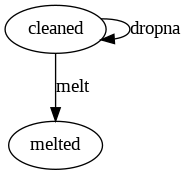

📓 Processing notebook: sample_nb10.ipynb

  🔄 Cell 0
  📦 Vars BEFORE: []
  ✅ DataFrames AFTER: ['penguins']

  🔄 Cell 1
  📦 Vars BEFORE: ['__builtins__', 'pd', 'penguins']
  ✅ DataFrames AFTER: ['penguins', 'species_lookup']

  🔄 Cell 2
  📦 Vars BEFORE: ['__builtins__', 'pd', 'penguins', 'species_lookup']
  ✅ DataFrames AFTER: ['penguins', 'species_lookup', 'filled']
    📎 filled ← fillna ← penguins

  🔄 Cell 3
  📦 Vars BEFORE: ['__builtins__', 'pd', 'penguins', 'species_lookup', '__warningregistry__', 'filled']
  ✅ DataFrames AFTER: ['penguins', 'species_lookup', 'filled', 'merged']
    📎 merged ← merge ← filled
    📎 merged ← merge ← species_lookup

  🔄 Cell 4
  📦 Vars BEFORE: ['__builtins__', 'pd', 'penguins', 'species_lookup', '__warningregistry__', 'filled', 'merged']
  ✅ DataFrames AFTER: ['penguins', 'species_lookup', 'filled', 'merged']

  📊 GroupBy Detected at Cell 4
  📁 param.json:
{
    "by": [
        "'type'"
    ],
    "value": [
        "body_mass_g"
    ]
}
  📁 op_seq.j

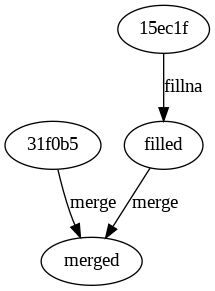

📓 Processing notebook: sample_nb5.ipynb

  🔄 Cell 0
  📦 Vars BEFORE: []
  ✅ DataFrames AFTER: ['flights']

  🔄 Cell 1
  📦 Vars BEFORE: ['__builtins__', 'pd', 'flights']
  ✅ DataFrames AFTER: ['flights']

  🔄 Cell 2
  📦 Vars BEFORE: ['__builtins__', 'pd', 'flights']
  ✅ DataFrames AFTER: ['flights', 'year_map']

  🔄 Cell 3
  📦 Vars BEFORE: ['__builtins__', 'pd', 'flights', 'year_map']
  ✅ DataFrames AFTER: ['flights', 'year_map', 'merged']
    📎 merged ← merge ← flights
    📎 merged ← merge ← year_map

  🔄 Cell 4
  📦 Vars BEFORE: ['__builtins__', 'pd', 'flights', 'year_map', 'merged']
  ✅ DataFrames AFTER: ['flights', 'year_map', 'merged', 'melted']
    📎 melted ← melt ← merged

  🔄 Cell 5
  📦 Vars BEFORE: ['__builtins__', 'pd', 'flights', 'year_map', 'merged', 'melted']
  ✅ DataFrames AFTER: ['flights', 'year_map', 'merged', 'melted', 'dropped']
    📎 dropped ← dropna ← melted

  🔄 Cell 6
  📦 Vars BEFORE: ['__builtins__', 'pd', 'flights', 'year_map', 'merged', 'melted', 'dropped']
  ✅ 

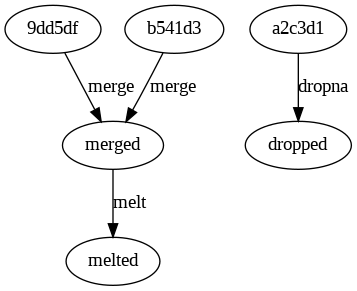

📓 Processing notebook: sample_nb7.ipynb

  🔄 Cell 0
  📦 Vars BEFORE: []
  ✅ DataFrames AFTER: ['titanic']

  🔄 Cell 1
  📦 Vars BEFORE: ['__builtins__', 'pd', 'titanic']
  ✅ DataFrames AFTER: ['titanic', 'combined']
    📎 combined ← concat ← titanic

  🔄 Cell 2
  📦 Vars BEFORE: ['__builtins__', 'pd', 'titanic', 'combined']
  ✅ DataFrames AFTER: ['titanic', 'combined', 'dropped']
    📎 dropped ← dropna ← combined

  🔄 Cell 3
  📦 Vars BEFORE: ['__builtins__', 'pd', 'titanic', 'combined', 'dropped']
  ✅ DataFrames AFTER: ['titanic', 'combined', 'dropped', 'filled']
    📎 filled ← fillna ← combined

  🔄 Cell 4
  📦 Vars BEFORE: ['__builtins__', 'pd', 'titanic', 'combined', 'dropped', 'filled']
  ✅ DataFrames AFTER: ['titanic', 'combined', 'dropped', 'filled', 'melted']
    📎 melted ← melt ← filled

  🔄 Cell 5
  📦 Vars BEFORE: ['__builtins__', 'pd', 'titanic', 'combined', 'dropped', 'filled', 'melted']
  ✅ DataFrames AFTER: ['titanic', 'combined', 'dropped', 'filled', 'melted', 'merged']
    

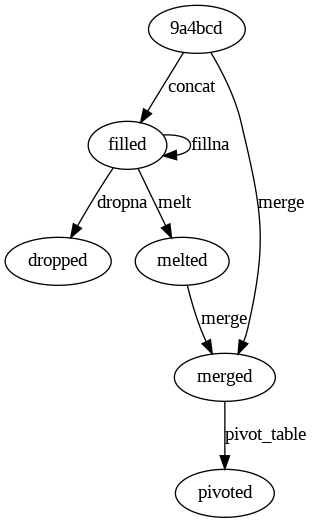

📓 Processing notebook: sample_nb2.ipynb

  🔄 Cell 0
  📦 Vars BEFORE: []
  ✅ DataFrames AFTER: ['titanic', 'ports']

  🔄 Cell 1
  📦 Vars BEFORE: ['__builtins__', 'pd', 'titanic', 'ports']
  ✅ DataFrames AFTER: ['titanic', 'ports']

  🔄 Cell 2
  📦 Vars BEFORE: ['__builtins__', 'pd', 'titanic', 'ports']
  ✅ DataFrames AFTER: ['titanic', 'ports', 'first_half', 'second_half', 'combined']
    📎 combined ← concat ← first_half
    📎 combined ← concat ← second_half

  🔄 Cell 3
  📦 Vars BEFORE: ['__builtins__', 'pd', 'titanic', 'ports', 'first_half', 'second_half', 'combined']
  ✅ DataFrames AFTER: ['titanic', 'ports', 'first_half', 'second_half', 'combined', 'dropped']
    📎 dropped ← dropna ← combined

  🔄 Cell 4
  📦 Vars BEFORE: ['__builtins__', 'pd', 'titanic', 'ports', 'first_half', 'second_half', 'combined', 'dropped']
  ✅ DataFrames AFTER: ['titanic', 'ports', 'first_half', 'second_half', 'combined', 'dropped']

  📊 GroupBy Detected at Cell 4
  📁 param.json:
{
    "by": [
        "'Pclass

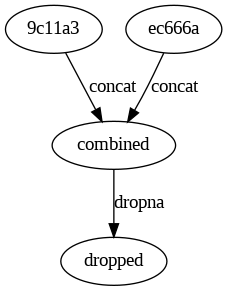

📓 Processing notebook: sample_nb8.ipynb

  🔄 Cell 0
  📦 Vars BEFORE: []
  ✅ DataFrames AFTER: ['flights']

  🔄 Cell 1
  📦 Vars BEFORE: ['__builtins__', 'pd', 'flights']
  ✅ DataFrames AFTER: ['flights', 'flights_filled']
    📎 flights_filled ← fillna ← flights

  🔄 Cell 2
  📦 Vars BEFORE: ['__builtins__', 'pd', 'flights', 'flights_filled']
  ✅ DataFrames AFTER: ['flights', 'flights_filled', 'flights_cleaned']
    📎 flights_cleaned ← dropna ← flights_filled

  🔄 Cell 3
  📦 Vars BEFORE: ['__builtins__', 'pd', 'flights', 'flights_filled', 'flights_cleaned']
  ✅ DataFrames AFTER: ['flights', 'flights_filled', 'flights_cleaned']

  📊 GroupBy Detected at Cell 3
  📁 param.json:
{
    "by": [
        "'year'"
    ],
    "value": [
        "passengers"
    ]
}
  📁 op_seq.json:
[
    "fillna",
    "dropna"
]

  🔄 Cell 4
  📦 Vars BEFORE: ['__builtins__', 'pd', 'flights', 'flights_filled', 'flights_cleaned', 'grouped']
  ✅ DataFrames AFTER: ['flights', 'flights_filled', 'flights_cleaned']
  📈 DAG 

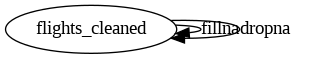

📓 Processing notebook: sample_nb4.ipynb

  🔄 Cell 0
  📦 Vars BEFORE: []
  ✅ DataFrames AFTER: ['penguins']

  🔄 Cell 1
  📦 Vars BEFORE: ['__builtins__', 'pd', 'penguins']
  ✅ DataFrames AFTER: ['penguins', 'filled']
    📎 filled ← fillna ← penguins

  🔄 Cell 2
  📦 Vars BEFORE: ['__builtins__', 'pd', 'penguins', 'filled']
  ✅ DataFrames AFTER: ['penguins', 'filled']

  📊 GroupBy Detected at Cell 2
  📁 param.json:
{
    "by": [
        "'species'"
    ],
    "value": [
        "bill_length_mm"
    ]
}
  📁 op_seq.json:
[
    "fillna"
]

  🔄 Cell 3
  📦 Vars BEFORE: ['__builtins__', 'pd', 'penguins', 'filled', 'grouped']
  ✅ DataFrames AFTER: ['penguins', 'filled', 'part1', 'part2', 'combined']
    📎 combined ← concat ← part1
    📎 combined ← concat ← part2

  🔄 Cell 4
  📦 Vars BEFORE: ['__builtins__', 'pd', 'penguins', 'filled', 'grouped', 'part1', 'part2', 'combined']
  ✅ DataFrames AFTER: ['penguins', 'filled', 'part1', 'part2', 'combined']
  📈 DAG saved as: /content/sample_nb4_graph.png

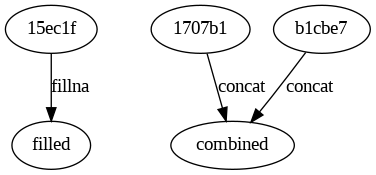

📓 Processing notebook: sample_nb6.ipynb

  🔄 Cell 0
  📦 Vars BEFORE: []
  ✅ DataFrames AFTER: ['titanic']

  🔄 Cell 1
  📦 Vars BEFORE: ['__builtins__', 'pd', 'titanic']
  ✅ DataFrames AFTER: ['titanic', 'filled_titanic']
    📎 filled_titanic ← fillna ← titanic

  🔄 Cell 2
  📦 Vars BEFORE: ['__builtins__', 'pd', 'titanic', 'filled_titanic']
  ✅ DataFrames AFTER: ['titanic', 'filled_titanic', 'dropped_titanic']
    📎 dropped_titanic ← dropna ← filled_titanic

  🔄 Cell 3
  📦 Vars BEFORE: ['__builtins__', 'pd', 'titanic', 'filled_titanic', 'dropped_titanic']
  ✅ DataFrames AFTER: ['titanic', 'filled_titanic', 'dropped_titanic', 'ports', 'merged_titanic']
    📎 merged_titanic ← merge ← dropped_titanic
    📎 merged_titanic ← merge ← ports

  🔄 Cell 4
  📦 Vars BEFORE: ['__builtins__', 'pd', 'titanic', 'filled_titanic', 'dropped_titanic', 'ports', 'merged_titanic']
  ✅ DataFrames AFTER: ['titanic', 'filled_titanic', 'dropped_titanic', 'ports', 'merged_titanic', 'melted_titanic']
    📎 melted_t

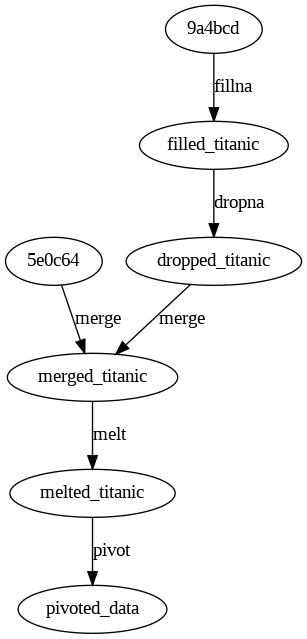

📓 Processing notebook: sample_nb3.ipynb

  🔄 Cell 0
  📦 Vars BEFORE: []
  ✅ DataFrames AFTER: ['tips']

  🔄 Cell 1
  📦 Vars BEFORE: ['__builtins__', 'pd', 'tips']
  ✅ DataFrames AFTER: ['tips']

  🔄 Cell 2
  📦 Vars BEFORE: ['__builtins__', 'pd', 'tips']
  ✅ DataFrames AFTER: ['tips', 'melted']
    📎 melted ← melt ← tips

  🔄 Cell 3
  📦 Vars BEFORE: ['__builtins__', 'pd', 'tips', 'melted']
  ✅ DataFrames AFTER: ['tips', 'melted', 'smoker_map', 'merged']
    📎 merged ← merge ← melted
    📎 merged ← merge ← smoker_map

  🔄 Cell 4
  📦 Vars BEFORE: ['__builtins__', 'pd', 'tips', 'melted', 'smoker_map', 'merged']
  ✅ DataFrames AFTER: ['tips', 'melted', 'smoker_map', 'merged', 'pivoted']
    📎 pivoted ← pivot_table ← merged

  🔄 Cell 5
  📦 Vars BEFORE: ['__builtins__', 'pd', 'tips', 'melted', 'smoker_map', 'merged', 'pivoted']
  ✅ DataFrames AFTER: ['tips', 'melted', 'smoker_map', 'merged', 'pivoted']
  📈 DAG saved as: /content/sample_nb3_graph.png



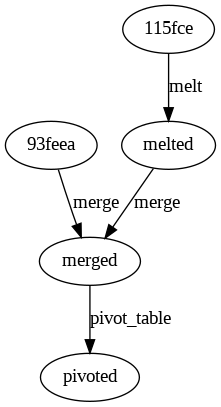

📓 Processing notebook: sample_nb1.ipynb

  🔄 Cell 0
  📦 Vars BEFORE: []
  ✅ DataFrames AFTER: ['titanic']

  🔄 Cell 1
  📦 Vars BEFORE: ['__builtins__', 'pd', 'titanic']
  ✅ DataFrames AFTER: ['titanic', 'filled_titanic']
    📎 filled_titanic ← fillna ← titanic

  🔄 Cell 2
  📦 Vars BEFORE: ['__builtins__', 'pd', 'titanic', 'filled_titanic']
  ✅ DataFrames AFTER: ['titanic', 'filled_titanic', 'dropped_titanic']
    📎 dropped_titanic ← dropna ← filled_titanic

  🔄 Cell 3
  📦 Vars BEFORE: ['__builtins__', 'pd', 'titanic', 'filled_titanic', 'dropped_titanic']
  ✅ DataFrames AFTER: ['titanic', 'filled_titanic', 'dropped_titanic']

  🔄 Cell 4
  📦 Vars BEFORE: ['__builtins__', 'pd', 'titanic', 'filled_titanic', 'dropped_titanic']
  ✅ DataFrames AFTER: ['titanic', 'filled_titanic', 'dropped_titanic']

  📊 GroupBy Detected at Cell 4
  📁 param.json:
{
    "by": [
        "'Pclass'"
    ],
    "value": [
        "Age"
    ]
}
  📁 op_seq.json:
[
    "fillna",
    "dropna"
]

  🔄 Cell 5
  📦 Vars BEF

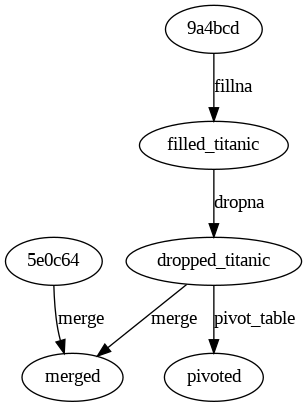

In [ ]:
# Replay All Notebooks with Debug and Graph Rendering
import os
import json
import hashlib
import nbformat
import pandas as pd
import ast
import contextlib
import re
from graphviz import Digraph
from IPython.display import Image, display

# Target operations to track
notebooks = [f for f in os.listdir('/content') if f.endswith('.ipynb')]
target_ops = ['dropna', 'fillna', 'concat', 'merge', 'melt', 'pivot', 'pivot_table', 'groupby']

print(f"\n🧠 Starting replaying {len(notebooks)} notebooks in total...\n")

for nb_name in notebooks:
    nb_path = os.path.join('/content', nb_name)
    with open(nb_path, 'r', encoding='utf-8') as f:
        nb = nbformat.read(f, as_version=4)

    execution_env = {}
    dataflow_graph = {}
    var_hash_map = {}
    output_map = {}  # maps hash → variable name

    print(f"📓 Processing notebook: {nb_name}")

    for idx, cell in enumerate(nb.cells):
        if cell.cell_type != 'code':
            continue

        code = cell.source
        try:
            ast_tree = ast.parse(code)
        except:
            continue

        for node in ast.walk(ast_tree):
            for child in ast.iter_child_nodes(node):
                child.parent = node

        print(f"\n  🔄 Cell {idx}")
        print(f"  📦 Vars BEFORE: {list(execution_env.keys())}")

        try:
            with suppress_output():
                exec(code, execution_env)
        except Exception as e:
            print(f"  ❌ Error: {e}")
            continue

        df_state = capture_dataframes(execution_env)
        print(f"  ✅ DataFrames AFTER: {list(df_state.keys())}")

        var_hash_map.update({name: h for name, (_, h) in df_state.items()})
        df_state_all = {**df_state}

        for node in ast.walk(ast_tree):
            if isinstance(node, ast.Call):
                func_name = node.func.attr if isinstance(node.func, ast.Attribute) else (
                    node.func.id if isinstance(node.func, ast.Name) else None)
                if func_name not in target_ops:
                    continue

                if hasattr(node.parent, 'targets') and isinstance(node.parent.targets[0], ast.Name):
                    output_name = node.parent.targets[0].id
                    if output_name not in df_state_all:
                        continue

                    output_hash = df_state_all[output_name][1]
                    output_map[output_hash] = output_name

                    base_vars = []
                    for subnode in ast.walk(node):
                        if isinstance(subnode, ast.Name) and subnode.id in var_hash_map and subnode.id not in base_vars:
                            base_vars.append(subnode.id)

                    if output_hash not in dataflow_graph:
                        dataflow_graph[output_hash] = {'parents': []}

                    for base_var in base_vars:
                        parent_hash = var_hash_map[base_var]
                        dataflow_graph[output_hash]['parents'].append((parent_hash, func_name))
                        print(f"    📎 {output_name} ← {func_name} ← {base_var}")

        for node in ast.walk(ast_tree):
            if isinstance(node, ast.Call):
                func_name = node.func.attr if isinstance(node.func, ast.Attribute) else None
                if func_name != 'groupby':
                    continue

                input_name = None
                if isinstance(node.func.value, ast.Name):
                    input_name = node.func.value.id
                elif isinstance(node.func.value, ast.Attribute):
                    if isinstance(node.func.value.value, ast.Name):
                        input_name = node.func.value.value.id

                if not input_name or input_name not in df_state:
                    continue

                input_df, input_hash = df_state[input_name]
                op_sequence = trace_full_upstream(input_hash, dataflow_graph)
                params = extract_groupby_params(code)


                print(f"\n  📊 GroupBy Detected at Cell {idx}")
                print("  📁 param.json:")
                print(json.dumps(params, indent=4))
                print("  📁 op_seq.json:")
                print(json.dumps(op_sequence, indent=4))

                print("============================================================")

    # Render the DAG using graphviz
    dot = Digraph(comment=f"DataFlow: {nb_name}", format='png')
    for node_hash, node_data in dataflow_graph.items():
        label = output_map.get(node_hash, node_hash[:6])
        dot.node(node_hash[:6], label)
        for parent_hash, op in node_data['parents']:
            dot.edge(parent_hash[:6], node_hash[:6], label=op)

    out_path = f"/content/{nb_name.replace('.ipynb', '')}_graph"
    dot.render(out_path, cleanup=True)
    print(f"  📈 DAG saved as: {out_path}.png\n")
    display(Image(filename=f"{out_path}.png"))
    print("  ============================================================")

### Replay and Save All Valid Notebooks

To ensure robust and consistent replaying of notebooks, this implementation filters out any notebooks that either $(1)$ use unsupported operations outside the target set (e.g., value_counts, apply, etc.), or $(2)$ fail during cell execution due to runtime errors such as missing columns or malformed expressions. Notebooks that encounter either of these issues are rejected and skipped from further processing. This guarantees that only structurally similar notebooks to our validated samples are analyzed and included in the operator graph and parameter extraction.


🧠 Starting replaying 11 notebooks in total...

📓 Processing notebook: sample_nb9.ipynb

  🔄 Cell 0
  📦 Vars BEFORE: []
  ✅ DataFrames AFTER: ['tips']

  🔄 Cell 1
  📦 Vars BEFORE: ['__builtins__', 'pd', 'tips']
  ✅ DataFrames AFTER: ['tips', 'cleaned']
    📎 cleaned ← dropna ← tips

  🔄 Cell 2
  📦 Vars BEFORE: ['__builtins__', 'pd', 'tips', 'cleaned']
  ✅ DataFrames AFTER: ['tips', 'cleaned', 'melted']
    📎 melted ← melt ← cleaned

  🔄 Cell 3
  📦 Vars BEFORE: ['__builtins__', 'pd', 'tips', 'cleaned', 'melted']
  ✅ DataFrames AFTER: ['tips', 'cleaned', 'melted']

  📊 GroupBy Detected at Cell 3
  📁 param.json:
{
    "by": [
        "time",
        "variable"
    ],
    "value": [
        "value"
    ]
}
  📁 op_seq.json:
[
    "dropna",
    "melt"
]
  📂 Saved extracted files to: /content/groupby/sample_nb9_cell3
  📈 DAG saved as: /content/sample_nb9_graph.png



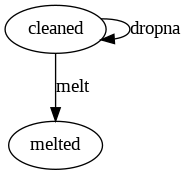

📓 Processing notebook: sample_nb10.ipynb

  🔄 Cell 0
  📦 Vars BEFORE: []
  ✅ DataFrames AFTER: ['penguins']

  🔄 Cell 1
  📦 Vars BEFORE: ['__builtins__', 'pd', 'penguins']
  ✅ DataFrames AFTER: ['penguins', 'species_lookup']

  🔄 Cell 2
  📦 Vars BEFORE: ['__builtins__', 'pd', 'penguins', 'species_lookup']
  ✅ DataFrames AFTER: ['penguins', 'species_lookup', 'filled']
    📎 filled ← fillna ← penguins

  🔄 Cell 3
  📦 Vars BEFORE: ['__builtins__', 'pd', 'penguins', 'species_lookup', '__warningregistry__', 'filled']
  ✅ DataFrames AFTER: ['penguins', 'species_lookup', 'filled', 'merged']
    📎 merged ← merge ← filled
    📎 merged ← merge ← species_lookup

  🔄 Cell 4
  📦 Vars BEFORE: ['__builtins__', 'pd', 'penguins', 'species_lookup', '__warningregistry__', 'filled', 'merged']
  ✅ DataFrames AFTER: ['penguins', 'species_lookup', 'filled', 'merged']

  📊 GroupBy Detected at Cell 4
  📁 param.json:
{
    "by": [
        "'type'"
    ],
    "value": [
        "body_mass_g"
    ]
}
  📁 op_seq.j

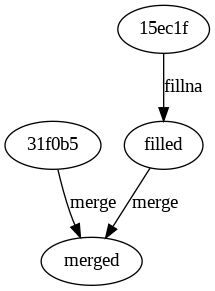

📓 Processing notebook: sample_nb5.ipynb

  🔄 Cell 0
  📦 Vars BEFORE: []
  ✅ DataFrames AFTER: ['flights']

  🔄 Cell 1
  📦 Vars BEFORE: ['__builtins__', 'pd', 'flights']
  ✅ DataFrames AFTER: ['flights']

  🔄 Cell 2
  📦 Vars BEFORE: ['__builtins__', 'pd', 'flights']
  ✅ DataFrames AFTER: ['flights', 'year_map']

  🔄 Cell 3
  📦 Vars BEFORE: ['__builtins__', 'pd', 'flights', 'year_map']
  ✅ DataFrames AFTER: ['flights', 'year_map', 'merged']
    📎 merged ← merge ← flights
    📎 merged ← merge ← year_map

  🔄 Cell 4
  📦 Vars BEFORE: ['__builtins__', 'pd', 'flights', 'year_map', 'merged']
  ✅ DataFrames AFTER: ['flights', 'year_map', 'merged', 'melted']
    📎 melted ← melt ← merged

  🔄 Cell 5
  📦 Vars BEFORE: ['__builtins__', 'pd', 'flights', 'year_map', 'merged', 'melted']
  ✅ DataFrames AFTER: ['flights', 'year_map', 'merged', 'melted', 'dropped']
    📎 dropped ← dropna ← melted

  🔄 Cell 6
  📦 Vars BEFORE: ['__builtins__', 'pd', 'flights', 'year_map', 'merged', 'melted', 'dropped']
  ✅ 

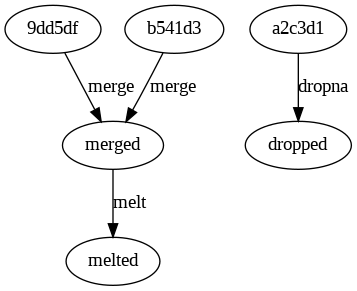

📓 Processing notebook: sample_nb11.ipynb

  🔄 Cell 0
  📦 Vars BEFORE: []
  ✅ DataFrames AFTER: []

  🔄 Cell 1
  📦 Vars BEFORE: ['__builtins__', 'pd']
  ✅ DataFrames AFTER: ['df']

  🔄 Cell 2
  📦 Vars BEFORE: ['__builtins__', 'pd', 'df']
  ✅ DataFrames AFTER: ['df']
⚠️ Notebook sample_nb11.ipynb did not contain a valid groupby operation — skipping saving results.

  📈 DAG saved as: /content/sample_nb11_graph.png



📓 Processing notebook: sample_nb7.ipynb

  🔄 Cell 0
  📦 Vars BEFORE: []
  ✅ DataFrames AFTER: ['titanic']

  🔄 Cell 1
  📦 Vars BEFORE: ['__builtins__', 'pd', 'titanic']
  ✅ DataFrames AFTER: ['titanic', 'combined']
    📎 combined ← concat ← titanic

  🔄 Cell 2
  📦 Vars BEFORE: ['__builtins__', 'pd', 'titanic', 'combined']
  ✅ DataFrames AFTER: ['titanic', 'combined', 'dropped']
    📎 dropped ← dropna ← combined

  🔄 Cell 3
  📦 Vars BEFORE: ['__builtins__', 'pd', 'titanic', 'combined', 'dropped']
  ✅ DataFrames AFTER: ['titanic', 'combined', 'dropped', 'filled']
    📎 filled ← fillna ← combined

  🔄 Cell 4
  📦 Vars BEFORE: ['__builtins__', 'pd', 'titanic', 'combined', 'dropped', 'filled']
  ✅ DataFrames AFTER: ['titanic', 'combined', 'dropped', 'filled', 'melted']
    📎 melted ← melt ← filled

  🔄 Cell 5
  📦 Vars BEFORE: ['__builtins__', 'pd', 'titanic', 'combined', 'dropped', 'filled', 'melted']
  ✅ DataFrames AFTER: ['titanic', 'combined', 'dropped', 'filled', 'melted', 'merged']
    

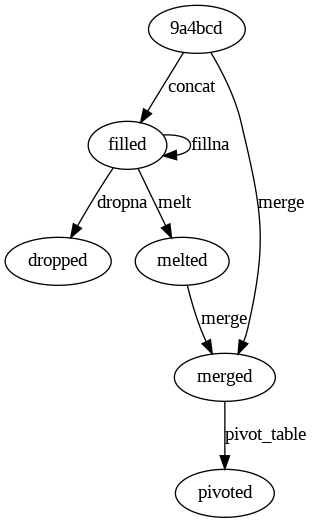

📓 Processing notebook: sample_nb2.ipynb

  🔄 Cell 0
  📦 Vars BEFORE: []
  ✅ DataFrames AFTER: ['titanic', 'ports']

  🔄 Cell 1
  📦 Vars BEFORE: ['__builtins__', 'pd', 'titanic', 'ports']
  ✅ DataFrames AFTER: ['titanic', 'ports']

  🔄 Cell 2
  📦 Vars BEFORE: ['__builtins__', 'pd', 'titanic', 'ports']
  ✅ DataFrames AFTER: ['titanic', 'ports', 'first_half', 'second_half', 'combined']
    📎 combined ← concat ← first_half
    📎 combined ← concat ← second_half

  🔄 Cell 3
  📦 Vars BEFORE: ['__builtins__', 'pd', 'titanic', 'ports', 'first_half', 'second_half', 'combined']
  ✅ DataFrames AFTER: ['titanic', 'ports', 'first_half', 'second_half', 'combined', 'dropped']
    📎 dropped ← dropna ← combined

  🔄 Cell 4
  📦 Vars BEFORE: ['__builtins__', 'pd', 'titanic', 'ports', 'first_half', 'second_half', 'combined', 'dropped']
  ✅ DataFrames AFTER: ['titanic', 'ports', 'first_half', 'second_half', 'combined', 'dropped']

  📊 GroupBy Detected at Cell 4
  📁 param.json:
{
    "by": [
        "'Pclass

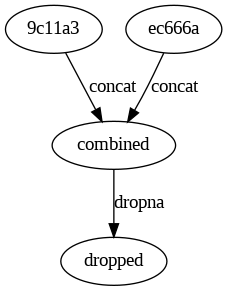

📓 Processing notebook: sample_nb8.ipynb

  🔄 Cell 0
  📦 Vars BEFORE: []
  ✅ DataFrames AFTER: ['flights']

  🔄 Cell 1
  📦 Vars BEFORE: ['__builtins__', 'pd', 'flights']
  ✅ DataFrames AFTER: ['flights', 'flights_filled']
    📎 flights_filled ← fillna ← flights

  🔄 Cell 2
  📦 Vars BEFORE: ['__builtins__', 'pd', 'flights', 'flights_filled']
  ✅ DataFrames AFTER: ['flights', 'flights_filled', 'flights_cleaned']
    📎 flights_cleaned ← dropna ← flights_filled

  🔄 Cell 3
  📦 Vars BEFORE: ['__builtins__', 'pd', 'flights', 'flights_filled', 'flights_cleaned']
  ✅ DataFrames AFTER: ['flights', 'flights_filled', 'flights_cleaned']

  📊 GroupBy Detected at Cell 3
  📁 param.json:
{
    "by": [
        "'year'"
    ],
    "value": [
        "passengers"
    ]
}
  📁 op_seq.json:
[
    "fillna",
    "dropna"
]
  📂 Saved extracted files to: /content/groupby/sample_nb8_cell3

  🔄 Cell 4
  📦 Vars BEFORE: ['__builtins__', 'pd', 'flights', 'flights_filled', 'flights_cleaned', 'grouped']
  ✅ DataFrames 

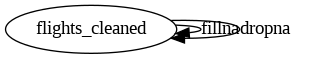

📓 Processing notebook: sample_nb4.ipynb

  🔄 Cell 0
  📦 Vars BEFORE: []
  ✅ DataFrames AFTER: ['penguins']

  🔄 Cell 1
  📦 Vars BEFORE: ['__builtins__', 'pd', 'penguins']
  ✅ DataFrames AFTER: ['penguins', 'filled']
    📎 filled ← fillna ← penguins

  🔄 Cell 2
  📦 Vars BEFORE: ['__builtins__', 'pd', 'penguins', 'filled']
  ✅ DataFrames AFTER: ['penguins', 'filled']

  📊 GroupBy Detected at Cell 2
  📁 param.json:
{
    "by": [
        "'species'"
    ],
    "value": [
        "bill_length_mm"
    ]
}
  📁 op_seq.json:
[
    "fillna"
]
  📂 Saved extracted files to: /content/groupby/sample_nb4_cell2

  🔄 Cell 3
  📦 Vars BEFORE: ['__builtins__', 'pd', 'penguins', 'filled', 'grouped']
  ✅ DataFrames AFTER: ['penguins', 'filled', 'part1', 'part2', 'combined']
    📎 combined ← concat ← part1
    📎 combined ← concat ← part2

  🔄 Cell 4
  📦 Vars BEFORE: ['__builtins__', 'pd', 'penguins', 'filled', 'grouped', 'part1', 'part2', 'combined']
  ✅ DataFrames AFTER: ['penguins', 'filled', 'part1', 'par

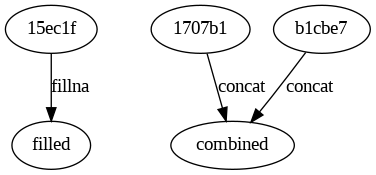

📓 Processing notebook: sample_nb6.ipynb

  🔄 Cell 0
  📦 Vars BEFORE: []
  ✅ DataFrames AFTER: ['titanic']

  🔄 Cell 1
  📦 Vars BEFORE: ['__builtins__', 'pd', 'titanic']
  ✅ DataFrames AFTER: ['titanic', 'filled_titanic']
    📎 filled_titanic ← fillna ← titanic

  🔄 Cell 2
  📦 Vars BEFORE: ['__builtins__', 'pd', 'titanic', 'filled_titanic']
  ✅ DataFrames AFTER: ['titanic', 'filled_titanic', 'dropped_titanic']
    📎 dropped_titanic ← dropna ← filled_titanic

  🔄 Cell 3
  📦 Vars BEFORE: ['__builtins__', 'pd', 'titanic', 'filled_titanic', 'dropped_titanic']
  ✅ DataFrames AFTER: ['titanic', 'filled_titanic', 'dropped_titanic', 'ports', 'merged_titanic']
    📎 merged_titanic ← merge ← dropped_titanic
    📎 merged_titanic ← merge ← ports

  🔄 Cell 4
  📦 Vars BEFORE: ['__builtins__', 'pd', 'titanic', 'filled_titanic', 'dropped_titanic', 'ports', 'merged_titanic']
  ✅ DataFrames AFTER: ['titanic', 'filled_titanic', 'dropped_titanic', 'ports', 'merged_titanic', 'melted_titanic']
    📎 melted_t

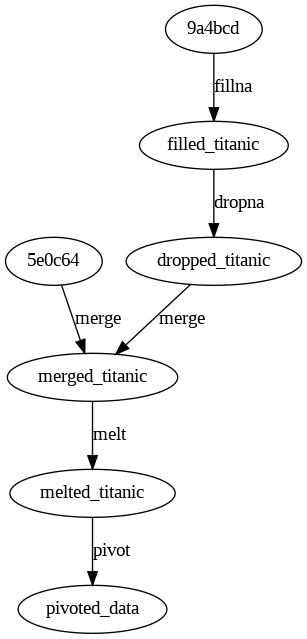

📓 Processing notebook: sample_nb3.ipynb

  🔄 Cell 0
  📦 Vars BEFORE: []
  ✅ DataFrames AFTER: ['tips']

  🔄 Cell 1
  📦 Vars BEFORE: ['__builtins__', 'pd', 'tips']
  ✅ DataFrames AFTER: ['tips']

  🔄 Cell 2
  📦 Vars BEFORE: ['__builtins__', 'pd', 'tips']
  ✅ DataFrames AFTER: ['tips', 'melted']
    📎 melted ← melt ← tips

  🔄 Cell 3
  📦 Vars BEFORE: ['__builtins__', 'pd', 'tips', 'melted']
  ✅ DataFrames AFTER: ['tips', 'melted', 'smoker_map', 'merged']
    📎 merged ← merge ← melted
    📎 merged ← merge ← smoker_map

  🔄 Cell 4
  📦 Vars BEFORE: ['__builtins__', 'pd', 'tips', 'melted', 'smoker_map', 'merged']
  ✅ DataFrames AFTER: ['tips', 'melted', 'smoker_map', 'merged', 'pivoted']
    📎 pivoted ← pivot_table ← merged

  🔄 Cell 5
  📦 Vars BEFORE: ['__builtins__', 'pd', 'tips', 'melted', 'smoker_map', 'merged', 'pivoted']
  ✅ DataFrames AFTER: ['tips', 'melted', 'smoker_map', 'merged', 'pivoted']
⚠️ Notebook sample_nb3.ipynb did not contain a valid groupby operation — skipping saving re

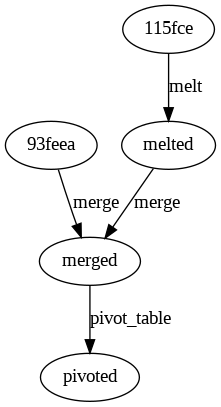

📓 Processing notebook: sample_nb1.ipynb

  🔄 Cell 0
  📦 Vars BEFORE: []
  ✅ DataFrames AFTER: ['titanic']

  🔄 Cell 1
  📦 Vars BEFORE: ['__builtins__', 'pd', 'titanic']
  ✅ DataFrames AFTER: ['titanic', 'filled_titanic']
    📎 filled_titanic ← fillna ← titanic

  🔄 Cell 2
  📦 Vars BEFORE: ['__builtins__', 'pd', 'titanic', 'filled_titanic']
  ✅ DataFrames AFTER: ['titanic', 'filled_titanic', 'dropped_titanic']
    📎 dropped_titanic ← dropna ← filled_titanic

  🔄 Cell 3
  📦 Vars BEFORE: ['__builtins__', 'pd', 'titanic', 'filled_titanic', 'dropped_titanic']
  ✅ DataFrames AFTER: ['titanic', 'filled_titanic', 'dropped_titanic']

  🔄 Cell 4
  📦 Vars BEFORE: ['__builtins__', 'pd', 'titanic', 'filled_titanic', 'dropped_titanic']
  ✅ DataFrames AFTER: ['titanic', 'filled_titanic', 'dropped_titanic']

  📊 GroupBy Detected at Cell 4
  📁 param.json:
{
    "by": [
        "'Pclass'"
    ],
    "value": [
        "Age"
    ]
}
  📁 op_seq.json:
[
    "fillna",
    "dropna"
]
  📂 Saved extracted file

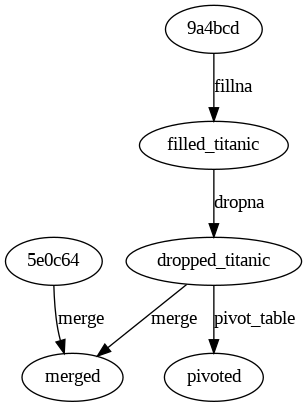

In [ ]:
# === Replay All Notebooks with Debug and Graph Rendering ===
# This script replays notebooks and extracts lineage of key pandas operations.
# To ensure the reliability of the resulting dataset, we add a new layer of notebook validation:
# - Notebooks with execution failures (e.g., missing columns in groupby) are excluded.
# - All operations are executed, but only groupby operations with valid lineage are saved.
# This allows us to preserve flexibility while filtering out structurally invalid groupby cases.
import os
import json
import hashlib
import nbformat
import pandas as pd
import ast
import contextlib
import re
from graphviz import Digraph
from IPython.display import Image, display

# Target operations to track
notebooks = [f for f in os.listdir('/content') if f.endswith('.ipynb')]
track_ops = ['dropna', 'fillna', 'concat', 'merge', 'melt', 'pivot', 'pivot_table', 'groupby']

print(f"\n🧠 Starting replaying {len(notebooks)} notebooks in total...\n")

for nb_name in notebooks:
    nb_path = os.path.join('/content', nb_name)
    with open(nb_path, 'r', encoding='utf-8') as f:
        nb = nbformat.read(f, as_version=4)

    execution_env = {}
    dataflow_graph = {}
    var_hash_map = {}
    output_map = {}  # maps hash → variable name
    fatal_exec_errors = False

    print(f"📓 Processing notebook: {nb_name}")

    for idx, cell in enumerate(nb.cells):
        if cell.cell_type != 'code':
            continue

        code = cell.source
        try:
            ast_tree = ast.parse(code)
        except:
            continue

        for node in ast.walk(ast_tree):
            for child in ast.iter_child_nodes(node):
                child.parent = node

        print(f"\n  🔄 Cell {idx}")
        print(f"  📦 Vars BEFORE: {list(execution_env.keys())}")

        try:
            with suppress_output():
                exec(code, execution_env)
        except Exception as e:
            print(f"  ❌ Execution error in notebook {nb_name} | Cell {idx}: {e}")
            fatal_exec_errors = True
            break

        df_state = capture_dataframes(execution_env)
        print(f"  ✅ DataFrames AFTER: {list(df_state.keys())}")

        var_hash_map.update({name: h for name, (_, h) in df_state.items()})
        df_state_all = {**df_state}

        for node in ast.walk(ast_tree):
            if isinstance(node, ast.Call):
                func_name = node.func.attr if isinstance(node.func, ast.Attribute) else (
                    node.func.id if isinstance(node.func, ast.Name) else None)

                if func_name not in track_ops:
                    continue

                if hasattr(node.parent, 'targets') and isinstance(node.parent.targets[0], ast.Name):
                    output_name = node.parent.targets[0].id
                    if output_name not in df_state_all:
                        continue

                    output_hash = df_state_all[output_name][1]
                    output_map[output_hash] = output_name

                    base_vars = []
                    for subnode in ast.walk(node):
                        if isinstance(subnode, ast.Name) and subnode.id in var_hash_map and subnode.id not in base_vars:
                            base_vars.append(subnode.id)

                    if output_hash not in dataflow_graph:
                        dataflow_graph[output_hash] = {'parents': []}

                    for base_var in base_vars:
                        parent_hash = var_hash_map[base_var]
                        dataflow_graph[output_hash]['parents'].append((parent_hash, func_name))
                        print(f"    📎 {output_name} ← {func_name} ← {base_var}")

        for node in ast.walk(ast_tree):
            if isinstance(node, ast.Call):
                func_name = node.func.attr if isinstance(node.func, ast.Attribute) else None
                if func_name != 'groupby':
                    continue

                input_name = None
                if isinstance(node.func.value, ast.Name):
                    input_name = node.func.value.id
                elif isinstance(node.func.value, ast.Attribute):
                    if isinstance(node.func.value.value, ast.Name):
                        input_name = node.func.value.value.id

                if not input_name or input_name not in df_state:
                    print(f"  ⚠️ Skipping invalid groupby in Cell {idx} — input '{input_name}' not found.")
                    continue

                input_df, input_hash = df_state[input_name]
                op_sequence = trace_full_upstream(input_hash, dataflow_graph)
                params = extract_groupby_params(code)

                print(f"\n  📊 GroupBy Detected at Cell {idx}")
                print("  📁 param.json:")
                print(json.dumps(params, indent=4))
                print("  📁 op_seq.json:")
                print(json.dumps(op_sequence, indent=4))

                print("============================================================")

                # === Save results ===
                save_dir = os.path.join("/content/groupby", f"{nb_name.replace('.ipynb', '')}_cell{idx}")
                os.makedirs(save_dir, exist_ok=True)

                with open(os.path.join(save_dir, 'param.json'), 'w') as f:
                    json.dump(params, f, indent=4)

                with open(os.path.join(save_dir, 'op_seq.json'), 'w') as f:
                    json.dump(op_sequence, f, indent=4)

                input_df.reset_index(drop=True).to_csv(os.path.join(save_dir, 'data.csv'), index=False)
                print(f"  📂 Saved extracted files to: {save_dir}")

    if fatal_exec_errors:
        print(f"❌ Rejected notebook: {nb_name} — execution failed on one or more cells.\n")

        continue

    if not any('groupby' in cell.source for cell in nb.cells if cell.cell_type == 'code'):
        print(f"⚠️ Notebook {nb_name} did not contain a valid groupby operation — skipping saving results.\n")


    # Render the DAG using graphviz
    dot = Digraph(comment=f"DataFlow: {nb_name}", format='png')
    for node_hash, node_data in dataflow_graph.items():
        label = output_map.get(node_hash, node_hash[:6])
        dot.node(node_hash[:6], label)
        for parent_hash, op in node_data['parents']:
            dot.edge(parent_hash[:6], node_hash[:6], label=op)

    out_path = f"/content/{nb_name.replace('.ipynb', '')}_graph"
    dot.render(out_path, cleanup=True)
    print(f"  📈 DAG saved as: {out_path}.png\n")
    display(Image(filename=f"{out_path}.png"))
    print("  ============================================================")

## Replay Process for for a  Single Notebook for Groupby, Merge, Melt and Pivot

In [ ]:
import os
import json
import hashlib
import nbformat
import pandas as pd
import ast
import contextlib
import re
from graphviz import Digraph
from IPython.display import Image, display

# === Shared Utility Functions ===
@contextlib.contextmanager
def suppress_output():
    import sys
    with open(os.devnull, 'w') as devnull:
        old_stdout, old_stderr = sys.stdout, sys.stderr
        sys.stdout, sys.stderr = devnull, devnull
        try:
            yield
        finally:
            sys.stdout, sys.stderr = old_stdout, old_stderr

def capture_dataframes(env):
    df_map = {}
    for name, obj in env.items():
        if isinstance(obj, pd.DataFrame):
            h = hashlib.md5(pd.util.hash_pandas_object(obj, index=True).values).hexdigest()
            df_map[name] = (obj.copy(), h)
    return df_map

def trace_full_upstream(df_hash, graph, visited=None):
    if visited is None:
        visited = set()
    if df_hash in visited or df_hash not in graph:
        return []
    visited.add(df_hash)
    ops = []
    for parent_hash, op in graph[df_hash]['parents']:
        ops += trace_full_upstream(parent_hash, graph, visited)
        ops.append(op)
    return list(dict.fromkeys(ops))

def extract_groupby_params(line):
    by_cols, value_cols = [], []
    match = re.search(r'groupby\((.*?)\)', line)
    if match:
        groupby_arg = match.group(1).strip()
        try:
            by_cols = eval(groupby_arg) if groupby_arg.startswith('[') else [groupby_arg]
        except:
            by_cols = [groupby_arg.strip("'").strip('"')]
    match_val = re.search(r'\)\s*\[\s*[\'"](.+?)[\'"]\s*\]', line)
    if match_val:
        value_cols = [match_val.group(1)]
    else:
        match_dot = re.search(r'\)\s*\.\s*([a-zA-Z_][a-zA-Z0-9_]*)', line)
        if match_dot:
            candidate = match_dot.group(1)
            if candidate.lower() not in ['mean', 'sum', 'count', 'max', 'min', 'median', 'std', 'var']:
                value_cols = [candidate]
    return {'by': by_cols, 'value': value_cols}

def extract_melt_params(line):
    id_vars, value_vars = [], []
    id_match = re.search(r'id_vars\s*=\s*(\[.*?\]|\".*?\"|\'.*?\')', line)
    val_match = re.search(r'value_vars\s*=\s*(\[.*?\]|\".*?\"|\'.*?\')', line)
    try:
        if id_match:
            id_vars = eval(id_match.group(1))
            if isinstance(id_vars, str):
                id_vars = [id_vars]
        if val_match:
            value_vars = eval(val_match.group(1))
            if isinstance(value_vars, str):
                value_vars = [value_vars]
    except:
        pass
    return {'id_vars': id_vars, 'value_vars': value_vars}

def extract_merge_params(line):
    left_on, right_on = None, None
    left_match = re.search(r'left_on\s*=\s*[\'"](\w+)[\'"]', line)
    right_match = re.search(r'right_on\s*=\s*[\'"](\w+)[\'"]', line)
    if left_match:
        left_on = left_match.group(1)
    if right_match:
        right_on = right_match.group(1)
    return {'left_on': left_on, 'right_on': right_on}

def extract_pivot_params(line):
    index, columns, values = [], [], []
    idx_match = re.search(r'index\s*=\s*(\[.*?\]|\".*?\"|\'.*?\')', line)
    col_match = re.search(r'columns\s*=\s*(\[.*?\]|\".*?\"|\'.*?\')', line)
    val_match = re.search(r'values\s*=\s*(\[.*?\]|\".*?\"|\'.*?\')', line)
    try:
        if idx_match:
            index = eval(idx_match.group(1))
            if isinstance(index, str):
                index = [index]
        if col_match:
            columns = eval(col_match.group(1))
            if isinstance(columns, str):
                columns = [columns]
        if val_match:
            values = eval(val_match.group(1))
            if isinstance(values, str):
                values = [values]
    except:
        pass
    return {'index': index, 'columns': columns, 'values': values}


📘 Replaying single notebook: sample_nb9.ipynb

🔹 Cell 0
📦 Vars BEFORE: []
✅ DataFrames AFTER: ['tips']

🔹 Cell 1
📦 Vars BEFORE: ['__builtins__', 'pd', 'tips']
✅ DataFrames AFTER: ['tips', 'cleaned']
🔁 cleaned ← dropna ← tips

🔹 Cell 2
📦 Vars BEFORE: ['__builtins__', 'pd', 'tips', 'cleaned']
✅ DataFrames AFTER: ['tips', 'cleaned', 'melted']
🔁 melted ← melt ← cleaned

📊 Melt Detected at Cell 2
📁 param.json:
{
    "id_vars": [
        "sex",
        "time"
    ],
    "value_vars": [
        "total_bill",
        "tip"
    ]
}
📁 op_seq.json:
[
    "dropna"
]
📂 Saved extracted files to: /content/melt/sample_nb9_cell2
📈 DAG saved as: /content/melt/sample_nb9_cell2/melt_graph.png


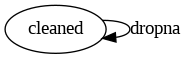


🔹 Cell 3
📦 Vars BEFORE: ['__builtins__', 'pd', 'tips', 'cleaned', 'melted']
✅ DataFrames AFTER: ['tips', 'cleaned', 'melted']

📊 Groupby Detected at Cell 3
📁 param.json:
{
    "by": [
        "time",
        "variable"
    ],
    "value": [
        "value"
    ]
}
📁 op_seq.json:
[
    "dropna",
    "melt"
]
📂 Saved extracted files to: /content/groupby/sample_nb9_cell3
📈 DAG saved as: /content/groupby/sample_nb9_cell3/groupby_graph.png


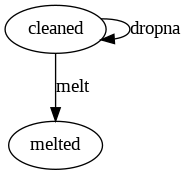

In [ ]:
# === SINGLE NOTEBOOK REPLAYER FOR ALL TARGET OPERATORS ===
notebook_path = '/content/sample_nb9.ipynb'
nb_name = os.path.basename(notebook_path)
track_ops = ['dropna', 'fillna', 'concat', 'merge', 'melt', 'pivot', 'pivot_table', 'groupby']
main_ops = ['groupby', 'merge', 'melt', 'pivot', 'pivot_table']

with open(notebook_path, 'r', encoding='utf-8') as f:
    nb = nbformat.read(f, as_version=4)

execution_env = {}
dataflow_graph = {}
var_hash_map = {}
output_map = {}
fatal_exec_errors = False

print(f"\n📘 Replaying single notebook: {nb_name}")

for idx, cell in enumerate(nb.cells):
    if cell.cell_type != 'code':
        continue

    code = cell.source
    try:
        ast_tree = ast.parse(code)
    except:
        continue

    for node in ast.walk(ast_tree):
        for child in ast.iter_child_nodes(node):
            child.parent = node

    print(f"\n🔹 Cell {idx}")
    print(f"📦 Vars BEFORE: {list(execution_env.keys())}")

    try:
        with suppress_output():
            exec(code, execution_env)
    except Exception as e:
        print(f"❌ Execution error in Cell {idx}: {e}")
        fatal_exec_errors = True
        break

    df_state = capture_dataframes(execution_env)
    print(f"✅ DataFrames AFTER: {list(df_state.keys())}")

    var_hash_map.update({name: h for name, (_, h) in df_state.items()})
    df_state_all = {**df_state}

    for node in ast.walk(ast_tree):
        if isinstance(node, ast.Call):
            func_name = node.func.attr if isinstance(node.func, ast.Attribute) else (
                node.func.id if isinstance(node.func, ast.Name) else None)
            if func_name not in track_ops:
                continue

            if hasattr(node.parent, 'targets') and isinstance(node.parent.targets[0], ast.Name):
                output_name = node.parent.targets[0].id
                if output_name not in df_state_all:
                    continue

                output_hash = df_state_all[output_name][1]
                output_map[output_hash] = output_name

                base_vars = []
                for subnode in ast.walk(node):
                    if isinstance(subnode, ast.Name) and subnode.id in var_hash_map and subnode.id not in base_vars:
                        base_vars.append(subnode.id)

                if output_hash not in dataflow_graph:
                    dataflow_graph[output_hash] = {'parents': []}

                for base_var in base_vars:
                    parent_hash = var_hash_map[base_var]
                    dataflow_graph[output_hash]['parents'].append((parent_hash, func_name))
                    print(f"🔁 {output_name} ← {func_name} ← {base_var}")

    for node in ast.walk(ast_tree):
        if isinstance(node, ast.Call):
            func_name = node.func.attr if isinstance(node.func, ast.Attribute) else None
            if func_name not in main_ops:
                continue

            # Extract input safely BEFORE using
            input_name = None
            if func_name in ['melt', 'merge']:
                for arg in node.args:
                    if isinstance(arg, ast.Name) and arg.id in df_state:
                        input_name = arg.id
                        break
            else:
                if isinstance(node.func.value, ast.Name):
                    input_name = node.func.value.id
                elif isinstance(node.func.value, ast.Attribute):
                    if isinstance(node.func.value.value, ast.Name):
                        input_name = node.func.value.value.id

            if not input_name or input_name not in df_state:
                print(f"⚠️ Skipping invalid {func_name} in Cell {idx} — input '{input_name}' not found.")
                continue

            input_df, input_hash = df_state[input_name]
            op_sequence = trace_full_upstream(input_hash, dataflow_graph)

            # Extract operation-specific parameters
            if func_name == 'groupby':
                params = extract_groupby_params(code)
            elif func_name == 'melt':
                params = extract_melt_params(code)
            elif func_name == 'merge':
                params = extract_merge_params(code)
            elif func_name in ['pivot', 'pivot_table']:
                params = extract_pivot_params(code)
                func_name = 'pivot'  # Normalize

            print(f"\n📊 {func_name.capitalize()} Detected at Cell {idx}")
            print("📁 param.json:")
            print(json.dumps(params, indent=4))
            print("📁 op_seq.json:")
            print(json.dumps(op_sequence, indent=4))

            # Save extracted data
            save_dir = os.path.join("/content", func_name, f"{nb_name.replace('.ipynb', '')}_cell{idx}")
            os.makedirs(save_dir, exist_ok=True)

            with open(os.path.join(save_dir, 'param.json'), 'w') as f:
                json.dump(params, f, indent=4)
            with open(os.path.join(save_dir, 'op_seq.json'), 'w') as f:
                json.dump(op_sequence, f, indent=4)
            input_df.reset_index(drop=True).to_csv(os.path.join(save_dir, 'data.csv'), index=False)

            print("============================================================")
            print(f"📂 Saved extracted files to: {save_dir}")

            # === Render per-operator DAG ===
            op_dot = Digraph(comment=f"{func_name.capitalize()} DAG Cell {idx}", format='png')
            visited_nodes = set()

            def add_node_recursive(h):
                if h in visited_nodes or h not in dataflow_graph:
                    return
                visited_nodes.add(h)
                op_dot.node(h[:6], output_map.get(h, h[:6]))
                for parent_h, op in dataflow_graph[h]['parents']:
                    op_dot.node(parent_h[:6], output_map.get(parent_h, parent_h[:6]))
                    op_dot.edge(parent_h[:6], h[:6], label=op)
                    add_node_recursive(parent_h)

            add_node_recursive(input_hash)
            graph_path = os.path.join(save_dir, f"{func_name}_graph")
            op_dot.render(graph_path, cleanup=True)
            print(f"📈 DAG saved as: {graph_path}.png")
            display(Image(filename=f"{graph_path}.png"))


## Replay Process for Multiple Notebooks for Groupby, Merge, Melt and Pivot

In [ ]:
# === UTILITY FUNCTIONS FOR MULTI-NOTEBOOK REPLAY ===
import os
import json
import hashlib
import nbformat
import pandas as pd
import ast
import contextlib
import re
from graphviz import Digraph
from IPython.display import Image, display

@contextlib.contextmanager
def suppress_output():
    import sys
    with open(os.devnull, 'w') as devnull:
        old_stdout, old_stderr = sys.stdout, sys.stderr
        sys.stdout, sys.stderr = devnull, devnull
        try:
            yield
        finally:
            sys.stdout, sys.stderr = old_stdout, old_stderr

def capture_dataframes(env):
    df_map = {}
    for name, obj in env.items():
        if isinstance(obj, pd.DataFrame):
            h = hashlib.md5(pd.util.hash_pandas_object(obj, index=True).values).hexdigest()
            df_map[name] = (obj.copy(), h)
    return df_map

def trace_full_upstream(df_hash, graph, visited=None):
    if visited is None:
        visited = set()
    if df_hash in visited or df_hash not in graph:
        return []
    visited.add(df_hash)
    ops = []
    for parent_hash, op in graph[df_hash]['parents']:
        ops += trace_full_upstream(parent_hash, graph, visited)
        ops.append(op)
    return list(dict.fromkeys(ops))

def extract_groupby_params(line):
    by_cols, value_cols = [], []
    match = re.search(r'groupby\((.*?)\)', line)
    if match:
        groupby_arg = match.group(1).strip()
        try:
            by_cols = eval(groupby_arg) if groupby_arg.startswith('[') else [groupby_arg]
        except:
            by_cols = [groupby_arg.strip("'").strip('"')]
    match_val = re.search(r'\)\s*\[\s*[\'"](.+?)[\'"]\s*\]', line)
    if match_val:
        value_cols = [match_val.group(1)]
    else:
        match_dot = re.search(r'\)\s*\.\s*([a-zA-Z_][a-zA-Z0-9_]*)', line)
        if match_dot:
            candidate = match_dot.group(1)
            if candidate.lower() not in ['mean', 'sum', 'count', 'max', 'min', 'median', 'std', 'var']:
                value_cols = [candidate]
    return {'by': by_cols, 'value': value_cols}

def extract_melt_params(line):
    id_vars, value_vars = [], []
    id_match = re.search(r'id_vars\s*=\s*(\[.*?\]|\".*?\"|\'.*?\')', line)
    val_match = re.search(r'value_vars\s*=\s*(\[.*?\]|\".*?\"|\'.*?\')', line)
    try:
        if id_match:
            id_vars = eval(id_match.group(1))
            if isinstance(id_vars, str):
                id_vars = [id_vars]
        if val_match:
            value_vars = eval(val_match.group(1))
            if isinstance(value_vars, str):
                value_vars = [value_vars]
    except:
        pass
    return {'id_vars': id_vars, 'value_vars': value_vars}

def extract_merge_params(line):
    # Default to None
    left_on, right_on, on = None, None, None

    on_match = re.search(r'on\s*=\s*[\'"](\w+)[\'"]', line)
    left_match = re.search(r'left_on\s*=\s*[\'"](\w+)[\'"]', line)
    right_match = re.search(r'right_on\s*=\s*[\'"](\w+)[\'"]', line)

    if on_match:
        on = on_match.group(1)
    if left_match:
        left_on = left_match.group(1)
    if right_match:
        right_on = right_match.group(1)

    # If "on" is provided but not left/right_on, assume both sides share that key
    if on and not (left_on or right_on):
        left_on = right_on = on

    return {'left_on': left_on, 'right_on': right_on}

def extract_pivot_params(line):
    index, columns, values = [], [], []
    idx_match = re.search(r'index\s*=\s*(\[.*?\]|\".*?\"|\'.*?\')', line)
    col_match = re.search(r'columns\s*=\s*(\[.*?\]|\".*?\"|\'.*?\')', line)
    val_match = re.search(r'values\s*=\s*(\[.*?\]|\".*?\"|\'.*?\')', line)
    try:
        if idx_match:
            index = eval(idx_match.group(1))
            if isinstance(index, str): index = [index]
        if col_match:
            columns = eval(col_match.group(1))
            if isinstance(columns, str): columns = [columns]
        if val_match:
            values = eval(val_match.group(1))
            if isinstance(values, str): values = [values]
    except:
        pass
    return {'index': index, 'columns': columns, 'values': values}

🔁 Replaying 11 notebooks...


📘 Processing: sample_nb9.ipynb

🔹 Cell 0
📦 Vars BEFORE: []
✅ DataFrames AFTER: ['tips']

🔹 Cell 1
📦 Vars BEFORE: ['__builtins__', 'pd', 'tips']
✅ DataFrames AFTER: ['tips', 'cleaned']

🔹 Cell 2
📦 Vars BEFORE: ['__builtins__', 'pd', 'tips', 'cleaned']
✅ DataFrames AFTER: ['tips', 'cleaned', 'melted']

📊 Melt Detected at Cell 2
📁 param.json:
{
    "id_vars": [
        "sex",
        "time"
    ],
    "value_vars": [
        "total_bill",
        "tip"
    ]
}
📁 op_seq.json:
[
    "dropna"
]
✅ melt → Saved: /content/melt/sample_nb9_cell2
📈 DAG saved as: /content/melt/sample_nb9_cell2/melt_graph.png


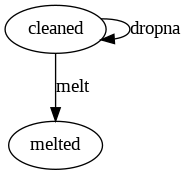


🔹 Cell 3
📦 Vars BEFORE: ['__builtins__', 'pd', 'tips', 'cleaned', 'melted']
✅ DataFrames AFTER: ['tips', 'cleaned', 'melted']

📊 Groupby Detected at Cell 3
📁 param.json:
{
    "by": [
        "time",
        "variable"
    ],
    "value": [
        "value"
    ]
}
📁 op_seq.json:
[
    "dropna",
    "melt"
]
✅ groupby → Saved: /content/groupby/sample_nb9_cell3
📈 DAG saved as: /content/groupby/sample_nb9_cell3/groupby_graph.png


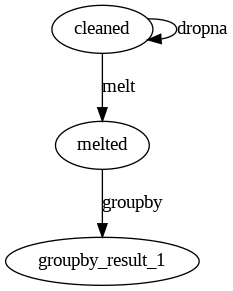


📘 Processing: sample_nb10.ipynb

🔹 Cell 0
📦 Vars BEFORE: []
✅ DataFrames AFTER: ['penguins']

🔹 Cell 1
📦 Vars BEFORE: ['__builtins__', 'pd', 'penguins']
✅ DataFrames AFTER: ['penguins', 'species_lookup']

🔹 Cell 2
📦 Vars BEFORE: ['__builtins__', 'pd', 'penguins', 'species_lookup']
✅ DataFrames AFTER: ['penguins', 'species_lookup', 'filled']

🔹 Cell 3
📦 Vars BEFORE: ['__builtins__', 'pd', 'penguins', 'species_lookup', '__warningregistry__', 'filled']
✅ DataFrames AFTER: ['penguins', 'species_lookup', 'filled', 'merged']

📊 Merge Detected at Cell 3
📁 param.json:
{
    "left_on": "species",
    "right_on": "species"
}
📁 op_seq.json:
[
    "fillna"
]
✅ merge → Saved: /content/merge/sample_nb10_cell3
📈 DAG saved as: /content/merge/sample_nb10_cell3/merge_graph.png


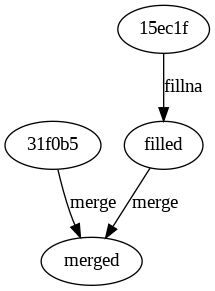


🔹 Cell 4
📦 Vars BEFORE: ['__builtins__', 'pd', 'penguins', 'species_lookup', '__warningregistry__', 'filled', 'merged']
✅ DataFrames AFTER: ['penguins', 'species_lookup', 'filled', 'merged']

📊 Groupby Detected at Cell 4
📁 param.json:
{
    "by": [
        "'type'"
    ],
    "value": [
        "body_mass_g"
    ]
}
📁 op_seq.json:
[
    "merge",
    "fillna"
]
✅ groupby → Saved: /content/groupby/sample_nb10_cell4
📈 DAG saved as: /content/groupby/sample_nb10_cell4/groupby_graph.png


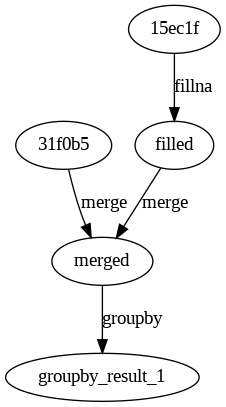


🔹 Cell 5
📦 Vars BEFORE: ['__builtins__', 'pd', 'penguins', 'species_lookup', '__warningregistry__', 'filled', 'merged', 'grouped']
✅ DataFrames AFTER: ['penguins', 'species_lookup', 'filled', 'merged']

📘 Processing: sample_nb5.ipynb

🔹 Cell 0
📦 Vars BEFORE: []
✅ DataFrames AFTER: ['flights']

🔹 Cell 1
📦 Vars BEFORE: ['__builtins__', 'pd', 'flights']
✅ DataFrames AFTER: ['flights']

🔹 Cell 2
📦 Vars BEFORE: ['__builtins__', 'pd', 'flights']
✅ DataFrames AFTER: ['flights', 'year_map']

🔹 Cell 3
📦 Vars BEFORE: ['__builtins__', 'pd', 'flights', 'year_map']
✅ DataFrames AFTER: ['flights', 'year_map', 'merged']

📊 Merge Detected at Cell 3
📁 param.json:
{
    "left_on": "year",
    "right_on": "year"
}
📁 op_seq.json:
[]
✅ merge → Saved: /content/merge/sample_nb5_cell3
📈 DAG saved as: /content/merge/sample_nb5_cell3/merge_graph.png


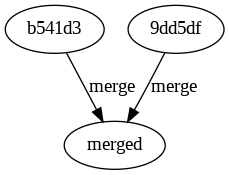


🔹 Cell 4
📦 Vars BEFORE: ['__builtins__', 'pd', 'flights', 'year_map', 'merged']
✅ DataFrames AFTER: ['flights', 'year_map', 'merged', 'melted']

📊 Melt Detected at Cell 4
📁 param.json:
{
    "id_vars": [
        "year",
        "month"
    ],
    "value_vars": [
        "passengers"
    ]
}
📁 op_seq.json:
[
    "merge"
]
✅ melt → Saved: /content/melt/sample_nb5_cell4
📈 DAG saved as: /content/melt/sample_nb5_cell4/melt_graph.png


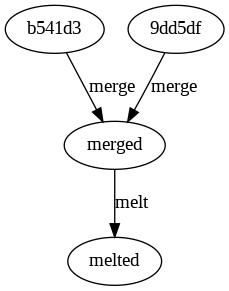


🔹 Cell 5
📦 Vars BEFORE: ['__builtins__', 'pd', 'flights', 'year_map', 'merged', 'melted']
✅ DataFrames AFTER: ['flights', 'year_map', 'merged', 'melted', 'dropped']

🔹 Cell 6
📦 Vars BEFORE: ['__builtins__', 'pd', 'flights', 'year_map', 'merged', 'melted', 'dropped']
✅ DataFrames AFTER: ['flights', 'year_map', 'merged', 'melted', 'dropped']

📘 Processing: sample_nb11.ipynb

🔹 Cell 0
📦 Vars BEFORE: []
✅ DataFrames AFTER: []

🔹 Cell 1
📦 Vars BEFORE: ['__builtins__', 'pd']
✅ DataFrames AFTER: ['df']

🔹 Cell 2
📦 Vars BEFORE: ['__builtins__', 'pd', 'df']
✅ DataFrames AFTER: ['df']

📘 Processing: sample_nb7.ipynb

🔹 Cell 0
📦 Vars BEFORE: []
✅ DataFrames AFTER: ['titanic']

🔹 Cell 1
📦 Vars BEFORE: ['__builtins__', 'pd', 'titanic']
✅ DataFrames AFTER: ['titanic', 'first_half', 'second_half', 'combined']

🔹 Cell 2
📦 Vars BEFORE: ['__builtins__', 'pd', 'titanic', 'first_half', 'second_half', 'combined']
✅ DataFrames AFTER: ['titanic', 'first_half', 'second_half', 'combined', 'dropped']

🔹 Cell 3

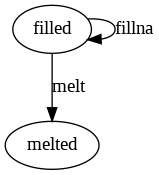


🔹 Cell 5
📦 Vars BEFORE: ['__builtins__', 'pd', 'titanic', 'first_half', 'second_half', 'combined', 'dropped', 'filled', 'melted']
✅ DataFrames AFTER: ['titanic', 'first_half', 'second_half', 'combined', 'dropped', 'filled', 'melted', 'titanic_short', 'merged']

📊 Merge Detected at Cell 5
📁 param.json:
{
    "left_on": "PassengerId",
    "right_on": "PassengerId"
}
📁 op_seq.json:
[
    "fillna",
    "melt"
]
✅ merge → Saved: /content/merge/sample_nb7_cell5
📈 DAG saved as: /content/merge/sample_nb7_cell5/merge_graph.png


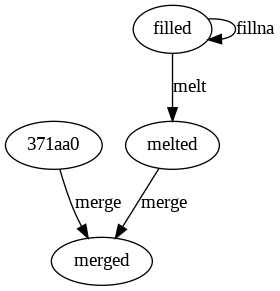


🔹 Cell 6
📦 Vars BEFORE: ['__builtins__', 'pd', 'titanic', 'first_half', 'second_half', 'combined', 'dropped', 'filled', 'melted', 'titanic_short', 'merged']
✅ DataFrames AFTER: ['titanic', 'first_half', 'second_half', 'combined', 'dropped', 'filled', 'melted', 'titanic_short', 'merged', 'pivoted']

📊 Pivot Detected at Cell 6
📁 param.json:
{
    "index": [
        "PassengerId"
    ],
    "columns": [
        "variable"
    ],
    "values": [
        "value"
    ]
}
📁 op_seq.json:
[
    "merge",
    "fillna",
    "melt"
]
✅ pivot → Saved: /content/pivot/sample_nb7_cell6
📈 DAG saved as: /content/pivot/sample_nb7_cell6/pivot_graph.png


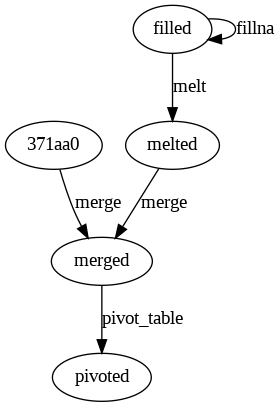


🔹 Cell 7
📦 Vars BEFORE: ['__builtins__', 'pd', 'titanic', 'first_half', 'second_half', 'combined', 'dropped', 'filled', 'melted', 'titanic_short', 'merged', 'pivoted']
✅ DataFrames AFTER: ['titanic', 'first_half', 'second_half', 'combined', 'dropped', 'filled', 'melted', 'titanic_short', 'merged', 'pivoted', 'grouped']

📊 Groupby Detected at Cell 7
📁 param.json:
{
    "by": [
        "pivoted.index"
    ],
    "value": []
}
📁 op_seq.json:
[
    "merge",
    "fillna",
    "melt",
    "pivot_table"
]
✅ groupby → Saved: /content/groupby/sample_nb7_cell7
📈 DAG saved as: /content/groupby/sample_nb7_cell7/groupby_graph.png


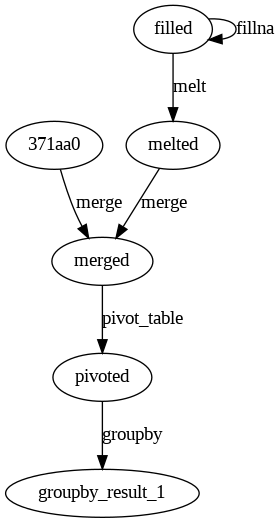


🔹 Cell 9
📦 Vars BEFORE: ['__builtins__', 'pd', 'titanic', 'first_half', 'second_half', 'combined', 'dropped', 'filled', 'melted', 'titanic_short', 'merged', 'pivoted', 'grouped']
✅ DataFrames AFTER: ['titanic', 'first_half', 'second_half', 'combined', 'dropped', 'filled', 'melted', 'titanic_short', 'merged', 'pivoted', 'grouped']

📘 Processing: sample_nb2.ipynb

🔹 Cell 0
📦 Vars BEFORE: []
✅ DataFrames AFTER: ['titanic', 'ports']

🔹 Cell 1
📦 Vars BEFORE: ['__builtins__', 'pd', 'titanic', 'ports']
✅ DataFrames AFTER: ['titanic', 'ports']

🔹 Cell 2
📦 Vars BEFORE: ['__builtins__', 'pd', 'titanic', 'ports']
✅ DataFrames AFTER: ['titanic', 'ports', 'first_half', 'second_half', 'combined']

🔹 Cell 3
📦 Vars BEFORE: ['__builtins__', 'pd', 'titanic', 'ports', 'first_half', 'second_half', 'combined']
✅ DataFrames AFTER: ['titanic', 'ports', 'first_half', 'second_half', 'combined', 'dropped']

🔹 Cell 4
📦 Vars BEFORE: ['__builtins__', 'pd', 'titanic', 'ports', 'first_half', 'second_half', 'combine

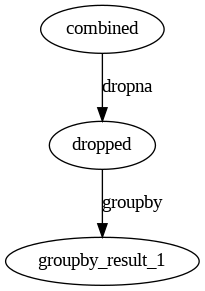


🔹 Cell 5
📦 Vars BEFORE: ['__builtins__', 'pd', 'titanic', 'ports', 'first_half', 'second_half', 'combined', 'dropped', 'grouped']
✅ DataFrames AFTER: ['titanic', 'ports', 'first_half', 'second_half', 'combined', 'dropped']

📘 Processing: sample_nb8.ipynb

🔹 Cell 0
📦 Vars BEFORE: []
✅ DataFrames AFTER: ['flights']

🔹 Cell 1
📦 Vars BEFORE: ['__builtins__', 'pd', 'flights']
✅ DataFrames AFTER: ['flights', 'flights_filled']

🔹 Cell 2
📦 Vars BEFORE: ['__builtins__', 'pd', 'flights', 'flights_filled']
✅ DataFrames AFTER: ['flights', 'flights_filled', 'flights_cleaned']

🔹 Cell 3
📦 Vars BEFORE: ['__builtins__', 'pd', 'flights', 'flights_filled', 'flights_cleaned']
✅ DataFrames AFTER: ['flights', 'flights_filled', 'flights_cleaned']

📊 Groupby Detected at Cell 3
📁 param.json:
{
    "by": [
        "'year'"
    ],
    "value": [
        "passengers"
    ]
}
📁 op_seq.json:
[
    "fillna",
    "dropna"
]
✅ groupby → Saved: /content/groupby/sample_nb8_cell3
📈 DAG saved as: /content/groupby/sample

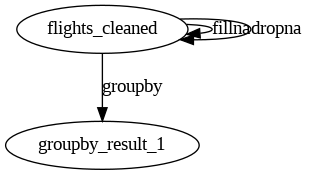


🔹 Cell 4
📦 Vars BEFORE: ['__builtins__', 'pd', 'flights', 'flights_filled', 'flights_cleaned', 'grouped']
✅ DataFrames AFTER: ['flights', 'flights_filled', 'flights_cleaned']

📘 Processing: sample_nb4.ipynb

🔹 Cell 0
📦 Vars BEFORE: []
✅ DataFrames AFTER: ['penguins']

🔹 Cell 1
📦 Vars BEFORE: ['__builtins__', 'pd', 'penguins']
✅ DataFrames AFTER: ['penguins', 'filled']

🔹 Cell 2
📦 Vars BEFORE: ['__builtins__', 'pd', 'penguins', 'filled']
✅ DataFrames AFTER: ['penguins', 'filled']

📊 Groupby Detected at Cell 2
📁 param.json:
{
    "by": [
        "'species'"
    ],
    "value": [
        "bill_length_mm"
    ]
}
📁 op_seq.json:
[
    "fillna"
]
✅ groupby → Saved: /content/groupby/sample_nb4_cell2
📈 DAG saved as: /content/groupby/sample_nb4_cell2/groupby_graph.png


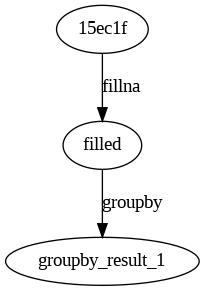


🔹 Cell 3
📦 Vars BEFORE: ['__builtins__', 'pd', 'penguins', 'filled', 'grouped']
✅ DataFrames AFTER: ['penguins', 'filled', 'part1', 'part2', 'combined']

🔹 Cell 4
📦 Vars BEFORE: ['__builtins__', 'pd', 'penguins', 'filled', 'grouped', 'part1', 'part2', 'combined']
✅ DataFrames AFTER: ['penguins', 'filled', 'part1', 'part2', 'combined']

📘 Processing: sample_nb6.ipynb

🔹 Cell 0
📦 Vars BEFORE: []
✅ DataFrames AFTER: ['titanic']

🔹 Cell 1
📦 Vars BEFORE: ['__builtins__', 'pd', 'titanic']
✅ DataFrames AFTER: ['titanic', 'filled_titanic']

🔹 Cell 2
📦 Vars BEFORE: ['__builtins__', 'pd', 'titanic', 'filled_titanic']
✅ DataFrames AFTER: ['titanic', 'filled_titanic', 'dropped_titanic']

🔹 Cell 3
📦 Vars BEFORE: ['__builtins__', 'pd', 'titanic', 'filled_titanic', 'dropped_titanic']
✅ DataFrames AFTER: ['titanic', 'filled_titanic', 'dropped_titanic', 'ports', 'merged_titanic']

📊 Merge Detected at Cell 3
📁 param.json:
{
    "left_on": "Embarked",
    "right_on": "Embarked"
}
📁 op_seq.json:
[
    "f

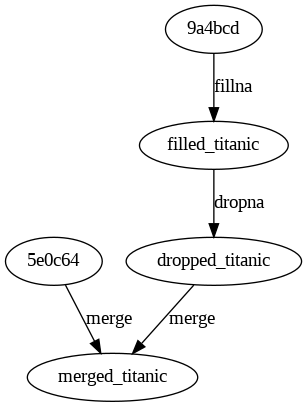


🔹 Cell 4
📦 Vars BEFORE: ['__builtins__', 'pd', 'titanic', 'filled_titanic', 'dropped_titanic', 'ports', 'merged_titanic']
✅ DataFrames AFTER: ['titanic', 'filled_titanic', 'dropped_titanic', 'ports', 'merged_titanic', 'melted_titanic']

📊 Melt Detected at Cell 4
📁 param.json:
{
    "id_vars": [
        "PassengerId"
    ],
    "value_vars": [
        "Age",
        "Fare"
    ]
}
📁 op_seq.json:
[
    "merge",
    "fillna",
    "dropna"
]
✅ melt → Saved: /content/melt/sample_nb6_cell4
📈 DAG saved as: /content/melt/sample_nb6_cell4/melt_graph.png


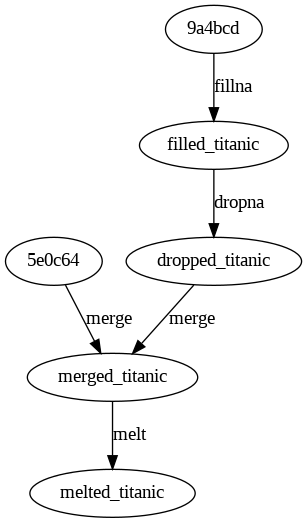


🔹 Cell 5
📦 Vars BEFORE: ['__builtins__', 'pd', 'titanic', 'filled_titanic', 'dropped_titanic', 'ports', 'merged_titanic', 'melted_titanic']
✅ DataFrames AFTER: ['titanic', 'filled_titanic', 'dropped_titanic', 'ports', 'merged_titanic', 'melted_titanic']

📊 Groupby Detected at Cell 5
📁 param.json:
{
    "by": [
        "Pclass",
        "Sex"
    ],
    "value": [
        "Fare"
    ]
}
📁 op_seq.json:
[
    "fillna",
    "dropna"
]
✅ groupby → Saved: /content/groupby/sample_nb6_cell5
📈 DAG saved as: /content/groupby/sample_nb6_cell5/groupby_graph.png


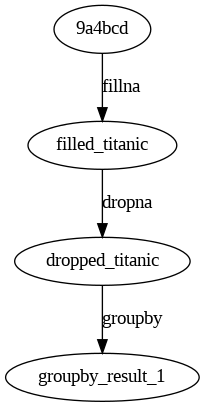


🔹 Cell 6
📦 Vars BEFORE: ['__builtins__', 'pd', 'titanic', 'filled_titanic', 'dropped_titanic', 'ports', 'merged_titanic', 'melted_titanic', 'grouped_data']
✅ DataFrames AFTER: ['titanic', 'filled_titanic', 'dropped_titanic', 'ports', 'merged_titanic', 'melted_titanic', 'pivoted_data']

📊 Pivot Detected at Cell 6
📁 param.json:
{
    "index": [
        "PassengerId"
    ],
    "columns": [
        "variable"
    ],
    "values": [
        "value"
    ]
}
📁 op_seq.json:
[
    "merge",
    "fillna",
    "dropna",
    "melt"
]
✅ pivot → Saved: /content/pivot/sample_nb6_cell6
📈 DAG saved as: /content/pivot/sample_nb6_cell6/pivot_graph.png


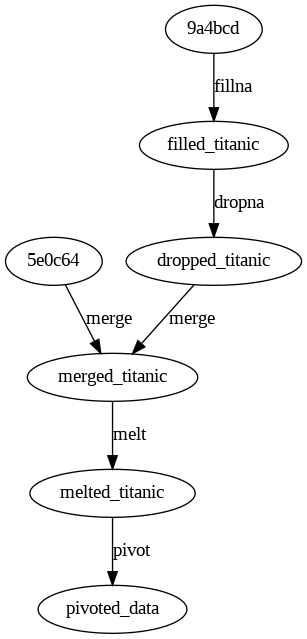


🔹 Cell 7
📦 Vars BEFORE: ['__builtins__', 'pd', 'titanic', 'filled_titanic', 'dropped_titanic', 'ports', 'merged_titanic', 'melted_titanic', 'grouped_data', 'pivoted_data']
✅ DataFrames AFTER: ['titanic', 'filled_titanic', 'dropped_titanic', 'ports', 'merged_titanic', 'melted_titanic', 'pivoted_data']

📘 Processing: sample_nb3.ipynb

🔹 Cell 0
📦 Vars BEFORE: []
✅ DataFrames AFTER: ['tips']

🔹 Cell 1
📦 Vars BEFORE: ['__builtins__', 'pd', 'tips']
✅ DataFrames AFTER: ['tips']

🔹 Cell 2
📦 Vars BEFORE: ['__builtins__', 'pd', 'tips']
✅ DataFrames AFTER: ['tips', 'melted']

📊 Melt Detected at Cell 2
📁 param.json:
{
    "id_vars": [
        "sex",
        "smoker"
    ],
    "value_vars": [
        "total_bill",
        "tip"
    ]
}
📁 op_seq.json:
[]
✅ melt → Saved: /content/melt/sample_nb3_cell2
📈 DAG saved as: /content/melt/sample_nb3_cell2/melt_graph.png


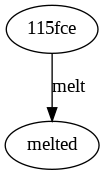


🔹 Cell 3
📦 Vars BEFORE: ['__builtins__', 'pd', 'tips', 'melted']
✅ DataFrames AFTER: ['tips', 'melted', 'smoker_map', 'merged']

📊 Merge Detected at Cell 3
📁 param.json:
{
    "left_on": "smoker",
    "right_on": "smoker"
}
📁 op_seq.json:
[
    "melt"
]
✅ merge → Saved: /content/merge/sample_nb3_cell3
📈 DAG saved as: /content/merge/sample_nb3_cell3/merge_graph.png


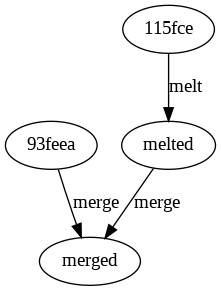


🔹 Cell 4
📦 Vars BEFORE: ['__builtins__', 'pd', 'tips', 'melted', 'smoker_map', 'merged']
✅ DataFrames AFTER: ['tips', 'melted', 'smoker_map', 'merged', 'pivoted']

📊 Pivot Detected at Cell 4
📁 param.json:
{
    "index": [
        "sex"
    ],
    "columns": [
        "smoker_status"
    ],
    "values": [
        "amount"
    ]
}
📁 op_seq.json:
[
    "merge",
    "melt"
]
✅ pivot → Saved: /content/pivot/sample_nb3_cell4
📈 DAG saved as: /content/pivot/sample_nb3_cell4/pivot_graph.png


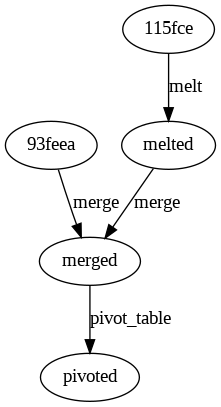


🔹 Cell 5
📦 Vars BEFORE: ['__builtins__', 'pd', 'tips', 'melted', 'smoker_map', 'merged', 'pivoted']
✅ DataFrames AFTER: ['tips', 'melted', 'smoker_map', 'merged', 'pivoted']

📘 Processing: sample_nb1.ipynb

🔹 Cell 0
📦 Vars BEFORE: []
✅ DataFrames AFTER: ['titanic']

🔹 Cell 1
📦 Vars BEFORE: ['__builtins__', 'pd', 'titanic']
✅ DataFrames AFTER: ['titanic', 'filled_titanic']

🔹 Cell 2
📦 Vars BEFORE: ['__builtins__', 'pd', 'titanic', 'filled_titanic']
✅ DataFrames AFTER: ['titanic', 'filled_titanic', 'dropped_titanic']

🔹 Cell 3
📦 Vars BEFORE: ['__builtins__', 'pd', 'titanic', 'filled_titanic', 'dropped_titanic']
✅ DataFrames AFTER: ['titanic', 'filled_titanic', 'dropped_titanic']

🔹 Cell 4
📦 Vars BEFORE: ['__builtins__', 'pd', 'titanic', 'filled_titanic', 'dropped_titanic']
✅ DataFrames AFTER: ['titanic', 'filled_titanic', 'dropped_titanic']

📊 Groupby Detected at Cell 4
📁 param.json:
{
    "by": [
        "'Pclass'"
    ],
    "value": [
        "Age"
    ]
}
📁 op_seq.json:
[
    "filln

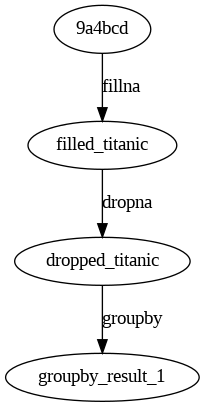


🔹 Cell 5
📦 Vars BEFORE: ['__builtins__', 'pd', 'titanic', 'filled_titanic', 'dropped_titanic', 'grouped_age']
✅ DataFrames AFTER: ['titanic', 'filled_titanic', 'dropped_titanic', 'pivoted']

📊 Pivot Detected at Cell 5
📁 param.json:
{
    "index": [
        "Pclass"
    ],
    "columns": [
        "Sex"
    ],
    "values": [
        "Fare"
    ]
}
📁 op_seq.json:
[
    "fillna",
    "dropna"
]
✅ pivot → Saved: /content/pivot/sample_nb1_cell5
📈 DAG saved as: /content/pivot/sample_nb1_cell5/pivot_graph.png


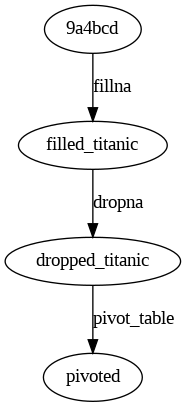


🔹 Cell 6
📦 Vars BEFORE: ['__builtins__', 'pd', 'titanic', 'filled_titanic', 'dropped_titanic', 'grouped_age', 'pivoted']
✅ DataFrames AFTER: ['titanic', 'filled_titanic', 'dropped_titanic', 'pivoted', 'ports', 'merged']

📊 Merge Detected at Cell 6
📁 param.json:
{
    "left_on": "Embarked",
    "right_on": "Embarked"
}
📁 op_seq.json:
[
    "fillna",
    "dropna"
]
✅ merge → Saved: /content/merge/sample_nb1_cell6
📈 DAG saved as: /content/merge/sample_nb1_cell6/merge_graph.png


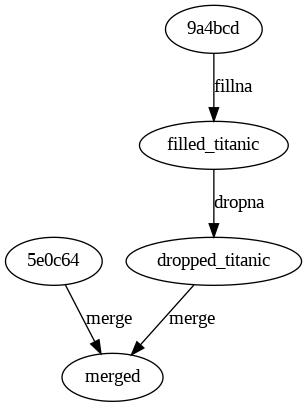


🔹 Cell 7
📦 Vars BEFORE: ['__builtins__', 'pd', 'titanic', 'filled_titanic', 'dropped_titanic', 'grouped_age', 'pivoted', 'ports', 'merged']
✅ DataFrames AFTER: ['titanic', 'filled_titanic', 'dropped_titanic', 'pivoted', 'ports', 'merged']


In [ ]:
# === REPLAY PROCESS FOR MULTIPLE NOTEBOOKS ===

# List all notebooks to process
notebooks = [f for f in os.listdir("/content") if f.endswith(".ipynb")]
track_ops = ['dropna', 'fillna', 'concat', 'merge', 'melt', 'pivot', 'pivot_table', 'groupby']
main_ops = ['groupby', 'merge', 'melt', 'pivot', 'pivot_table']

print(f"🔁 Replaying {len(notebooks)} notebooks...\n")

for nb_name in notebooks:
    print(f"\n📘 Processing: {nb_name}")
    nb_path = os.path.join("/content", nb_name)

    try:
        with open(nb_path, 'r', encoding='utf-8') as f:
            nb = nbformat.read(f, as_version=4)
    except Exception as e:
        print(f"❌ Failed to open {nb_name}: {e}")
        continue

    execution_env = {}
    dataflow_graph = {}
    var_hash_map = {}
    output_map = {}

    for idx, cell in enumerate(nb.cells):
        if cell.cell_type != 'code':
            continue

        code = cell.source
        try:
            ast_tree = ast.parse(code)
        except:
            continue

        for node in ast.walk(ast_tree):
            for child in ast.iter_child_nodes(node):
                child.parent = node

        print(f"\n🔹 Cell {idx}")
        print(f"📦 Vars BEFORE: {list(execution_env.keys())}")

        try:
            with suppress_output():
                exec(code, execution_env)
        except Exception as e:
            print(f"❌ Error executing cell {idx}: {e}")
            break

        # Capture all current DataFrames and compute their hashes
        df_state = capture_dataframes(execution_env)
        for name, (df_obj, h) in df_state.items():
            var_hash_map[name] = h

        # Force capture of chained assignments like groupby().mean()
        for node in ast.walk(ast_tree):
            if hasattr(node, 'targets') and isinstance(node.targets[0], ast.Name):
                var_name = node.targets[0].id
                val = execution_env.get(var_name)
                if isinstance(val, pd.DataFrame):
                    h = hashlib.md5(pd.util.hash_pandas_object(val, index=True).values).hexdigest()
                    var_hash_map[var_name] = h
                    df_state[var_name] = (val, h)

        # Merge all known DataFrames
        df_state_all = {
            name: (execution_env[name], var_hash_map[name])
            for name in var_hash_map
            if name in execution_env and isinstance(execution_env[name], pd.DataFrame)
        }

        print(f"✅ DataFrames AFTER: {list(df_state_all.keys())}")

        # === FIRST PASS: build dataflow graph ===
        synthetic_groupby_idx = 0
        for node in ast.walk(ast_tree):
            if isinstance(node, ast.Call):
                func_name = node.func.attr if isinstance(node.func, ast.Attribute) else (
                    node.func.id if isinstance(node.func, ast.Name) else None)
                if func_name not in track_ops:
                    continue

                output_name = None
                if hasattr(node.parent, 'targets') and isinstance(node.parent.targets[0], ast.Name):
                    output_name = node.parent.targets[0].id

                output_hash = None
                if output_name in df_state_all:
                    output_hash = df_state_all[output_name][1]
                    output_map[output_hash] = output_name

                base_vars = set()
                for arg in node.args:
                    if isinstance(arg, ast.Name) and arg.id in var_hash_map:
                        base_vars.add(arg.id)
                if hasattr(node.func, 'value'):
                    base = node.func.value
                    if isinstance(base, ast.Name) and base.id in var_hash_map:
                        base_vars.add(base.id)
                    elif isinstance(base, ast.Attribute) and isinstance(base.value, ast.Name):
                        base_vars.add(base.value.id)

                if not output_hash and func_name == 'groupby':
                    synthetic_groupby_idx += 1
                    output_hash = f"__groupby_result_{nb_name}_cell{idx}_{synthetic_groupby_idx}__"
                    output_map[output_hash] = f"groupby_result_{synthetic_groupby_idx}"
                target_hash = output_hash or f"__implicit_{idx}_{func_name}__"
                if target_hash not in dataflow_graph:
                    dataflow_graph[target_hash] = {'parents': []}
                for base_var in base_vars:
                    parent_hash = var_hash_map.get(base_var)
                    if parent_hash:
                        dataflow_graph[target_hash]['parents'].append((parent_hash, func_name))

        # === SECOND PASS: detect main ops and save results ===
        for node in ast.walk(ast_tree):
            if isinstance(node, ast.Call):
                # ✅ Skip if this call is part of a larger expression like groupby(...).mean()
                if hasattr(node, 'parent') and isinstance(node.parent, ast.Call):
                    continue

                func_name = node.func.attr if isinstance(node.func, ast.Attribute) else None
                if func_name not in main_ops:
                    continue

                input_name = None
                if func_name in ['melt', 'merge']:
                    for arg in node.args:
                        if isinstance(arg, ast.Name) and arg.id in df_state_all:
                            input_name = arg.id
                            break
                else:
                    if isinstance(node.func.value, ast.Name):
                        input_name = node.func.value.id
                    elif isinstance(node.func.value, ast.Attribute):
                        if isinstance(node.func.value.value, ast.Name):
                            input_name = node.func.value.value.id

                if not input_name or input_name not in df_state_all:
                    continue

                input_df, input_hash = df_state_all[input_name]
                op_sequence = trace_full_upstream(input_hash, dataflow_graph)

                if func_name == 'groupby':
                    params = extract_groupby_params(code)
                elif func_name == 'melt':
                    params = extract_melt_params(code)
                elif func_name == 'merge':
                    params = extract_merge_params(code)
                elif func_name in ['pivot', 'pivot_table']:
                    params = extract_pivot_params(code)
                    func_name = 'pivot'

                print(f"\n📊 {func_name.capitalize()} Detected at Cell {idx}")
                print("📁 param.json:")
                print(json.dumps(params, indent=4))
                print("📁 op_seq.json:")
                print(json.dumps(op_sequence, indent=4))

                save_dir = os.path.join("/content", func_name, f"{nb_name.replace('.ipynb', '')}_cell{idx}")
                os.makedirs(save_dir, exist_ok=True)

                with open(os.path.join(save_dir, 'param.json'), 'w') as f:
                    json.dump(params, f, indent=4)
                with open(os.path.join(save_dir, 'op_seq.json'), 'w') as f:
                    json.dump(op_sequence, f, indent=4)
                input_df.reset_index(drop=True).to_csv(os.path.join(save_dir, 'data.csv'), index=False)

                print(f"✅ {func_name} → Saved: {save_dir}")

                # === Render DAG ===
                op_dot = Digraph(comment=f"{func_name.capitalize()} DAG Cell {idx}", format='png')
                visited_nodes = set()

                def add_node_recursive(h):
                    if h in visited_nodes or h not in dataflow_graph:
                        return
                    visited_nodes.add(h)
                    op_dot.node(h[:6], output_map.get(h, h[:6]))
                    for parent_h, op in dataflow_graph[h]['parents']:
                        op_dot.node(parent_h[:6], output_map.get(parent_h, parent_h[:6]))
                        op_dot.edge(parent_h[:6], h[:6], label=op)
                        add_node_recursive(parent_h)

                add_node_recursive(output_hash or input_hash)
                graph_path = os.path.join(save_dir, f"{func_name}_graph")
                op_dot.render(graph_path, cleanup=True)
                print(f"📈 DAG saved as: {graph_path}.png")
                display(Image(filename=f"{graph_path}.png"))

While the replay system is robust across most use cases, there are a few known edge cases where it may not produce the expected outputs:
*   Complex inline expressions in merge fail without intermediate assignment: When performing a merge like pd.merge(melted, titanic[['PassengerId', 'Survived']]), the inner DataFrame (titanic[...]) has no variable name, so it can't be traced or hashed. To make this traceable, the slicing operation must be assigned first (e.g., titanic_short = titanic[['PassengerId', 'Survived']]) and then passed to merge.
*   GroupBy output nodes are hardcoded in the DAG as groupby_result_X: Since groupby(...).agg() and similar expressions often occur in chains, the actual groupby call is buried inside larger expressions. To ensure it still appears in the DAG, a synthetic node label like groupby_result_1 is created, because there's no direct variable assignment to hook into.
*   DAG sequences may start from mid-operations if not linked properly: In sequences where  concat is parent for both fillna and dropna nodes and the next operation of melt is after the fillna, the concat is not in the resulting melt sequence. This breaks full upstream tracking due to the loss of a named reference to the original concat.

Additionally, there is an implicit notebook validity check: notebooks that fail to execute (e.g., due to syntax errors or missing variables) are automatically skipped and their operations are not recorded. This ensures only successfully replayed notebooks with well-formed operator sequences contribute to the extracted dataset.

## Download Github Notebooks

### Download Specific Notebooks along with their Datasets

In [ ]:
# === Step 1: Clone specific GitHub Repos locally ===
import os
import subprocess

# Define specific github URLs for test repos
test_repos = {
    "test_repo_1": "https://github.com/GiX007/test_repo_1.git",
    "test_repo_2": "https://github.com/GiX007/test_repo_2.git",
    "test_repo_3": "https://github.com/GiX007/test_repo_3.git",
    "test_repo_4": "https://github.com/GiX007/test_repo_4.git",
    "test_repo_5": "https://github.com/GiX007/test_repo_5.git",
    "test_repo_7": "https://github.com/GiX007/test_repo_7.git"
}

# Target clone directory
base_dir = "/content/specific_github_test_repos"
os.makedirs(base_dir, exist_ok=True)

# Clone each repo
for name, url in test_repos.items():
    repo_path = os.path.join(base_dir, name)
    if not os.path.exists(repo_path):
        print(f"📥 Cloning {name}...")
        subprocess.run(["git", "clone", url, repo_path])
    else:
        print(f"✅ {name} already cloned.")

# Confirm structure
print("\n📂 Contents of cloned base directory:")
for root, dirs, files in os.walk(base_dir):
    for file in files:
        print(os.path.join(root, file))

📥 Cloning test_repo_1...
📥 Cloning test_repo_2...
📥 Cloning test_repo_3...
📥 Cloning test_repo_4...
📥 Cloning test_repo_5...
📥 Cloning test_repo_7...

📂 Contents of cloned base directory:
/content/specific_github_test_repos/test_repo_3/sample_nb3.ipynb
/content/specific_github_test_repos/test_repo_3/.git/index
/content/specific_github_test_repos/test_repo_3/.git/config
/content/specific_github_test_repos/test_repo_3/.git/HEAD
/content/specific_github_test_repos/test_repo_3/.git/description
/content/specific_github_test_repos/test_repo_3/.git/packed-refs
/content/specific_github_test_repos/test_repo_3/.git/info/exclude
/content/specific_github_test_repos/test_repo_3/.git/hooks/commit-msg.sample
/content/specific_github_test_repos/test_repo_3/.git/hooks/applypatch-msg.sample
/content/specific_github_test_repos/test_repo_3/.git/hooks/pre-push.sample
/content/specific_github_test_repos/test_repo_3/.git/hooks/pre-receive.sample
/content/specific_github_test_repos/test_repo_3/.git/hooks/pre-

In [ ]:
# === Step 2: Extract dataset references from notebooks ===
import nbformat
import re

notebook_infos = []

# define a pattern that finds whatever is inside in read_csv/read_table usage (e.g. pd.read_csv("data.csv"))
# pd.read_csv(file_path) is Not detected
read_csv_pattern = re.compile(r"""(?:read_csv|read_table)\((.*?)\)""")

# iterate over all repos
for repo_name in os.listdir(base_dir):
    repo_path = os.path.join(base_dir, repo_name)

    # iterate over all contents in the current repo
    for file in os.listdir(repo_path):

        # check if a noteboo exists inside here
        if file.endswith(".ipynb"):
            nb_path = os.path.join(repo_path, file)

            # Load the notebook in python object
            with open(nb_path, 'r', encoding='utf-8') as f:
                nb = nbformat.read(f, as_version=4)

            # Go through each cell and extract dataset references
            for cell in nb.cells:
                if cell.cell_type != 'code':
                    continue

                # apply the pattern defined above to extract everything inside read_csv, read_table, e.g. "'data/titanic.csv', sep=';'"
                matches = read_csv_pattern.findall(cell.source)

                for match in matches:
                    # Try to extract string inside quotes → the actual file name or URL, e.g. "data/titanic.csv"
                    path_match = re.search(r"['\"](.*?)['\"]", match)

                    if path_match:
                        dataset_ref = path_match.group(1)  # This is either the filename or the URL

                        # Save all relevant info
                        notebook_infos.append({
                            "repo": repo_name,                      # Repo name: e.g., test_repo_2
                            "notebook": file,                       # Notebook file name: e.g., sample_nb2.ipynb
                            "dataset_ref": dataset_ref,             # Extracted value inside read_csv(): 'data/titanic.csv' or URL
                            "full_path": nb_path,                   # Full path to notebook
                            "cell": cell.source.strip()             # Code cell content (useful for context later)
                        })

# Display what we captured
print(f"🔍 Found {len(notebook_infos)} dataset references:")
for info in notebook_infos:
    print(info)

🔍 Found 6 dataset references:
{'repo': 'test_repo_3', 'notebook': 'sample_nb3.ipynb', 'dataset_ref': 'https://raw.githubusercontent.com/mwaskom/seaborn-data/master/tips.csv', 'full_path': '/content/specific_github_test_repos/test_repo_3/sample_nb3.ipynb', 'cell': "# operations: melt, merge, pivot using Tips dataset\nimport pandas as pd\n\ntips = pd.read_csv('https://raw.githubusercontent.com/mwaskom/seaborn-data/master/tips.csv')"}
{'repo': 'test_repo_4', 'notebook': 'sample_nb4.ipynb', 'dataset_ref': 'https://raw.githubusercontent.com/mwaskom/seaborn-data/master/penguins.csv', 'full_path': '/content/specific_github_test_repos/test_repo_4/sample_nb4.ipynb', 'cell': "# operations: fillna, groupby, concat using Penguins dataset\nimport pandas as pd\n\npenguins = pd.read_csv('https://raw.githubusercontent.com/mwaskom/seaborn-data/master/penguins.csv')"}
{'repo': 'test_repo_2', 'notebook': 'sample_nb2.ipynb', 'dataset_ref': 'data/titanic.csv', 'full_path': '/content/specific_github_test_re

In [ ]:
# === Step 3: Attempt to resolve dataset references ===
import requests

resolved_datasets = []

for info in notebook_infos:
    dataset_path = info['dataset_ref']         # This might be a path, URL, or filename
    repo_dir = os.path.join(base_dir, info['repo'])
    full_file_path = os.path.join(repo_dir, dataset_path)

    # Case 1: File exists locally
    if os.path.exists(full_file_path):
        category = "local_file"
        resolved_path = full_file_path
        print(f"✅ [{info['notebook']}] Found local dataset: {dataset_path}")

    # Case 2: It's a URL → download it if possible
    elif dataset_path.startswith("http"):
        category = "url"
        try:
            response = requests.get(dataset_path)
            if response.status_code == 200:
                local_filename = os.path.join(repo_dir, os.path.basename(dataset_path))
                with open(local_filename, 'wb') as f:
                    f.write(response.content)
                resolved_path = local_filename
                print(f"🌐 [{info['notebook']}] Downloaded dataset from URL: {dataset_path}")
            else:
                resolved_path = None
                print(f"⚠️ [{info['notebook']}] Failed to download dataset from: {dataset_path} (status code {response.status_code})")
        except Exception as e:
            print(f"⚠️ [{info['notebook']}] Error while downloading {dataset_path}: {e}")
            resolved_path = None

    # Case 3: Just a filename (e.g., 'flights.csv') — unresolved
    else:
        category = "unresolved_filename"
        resolved_path = None
        print(f"❓ [{info['notebook']}] Could not resolve dataset: {dataset_path} (will require fallback e.g. Kaggle)")

    # Save result
    resolved_datasets.append({
        **info,
        "resolved_path": resolved_path,
        "category": category
    })

# Summary
#print(f"\n📦 Resolution summary for {len(resolved_datasets)} datasets:")
#print(resolved_datasets)

# Final Summary Print
print("\n📦 Final dataset resolution summary:")
for entry in resolved_datasets:
    print(f"📁 Repo: {entry['repo']}, 📓 Notebook: {entry['notebook']}, 🏷️ Category: {entry['category']}")

🌐 [sample_nb3.ipynb] Downloaded dataset from URL: https://raw.githubusercontent.com/mwaskom/seaborn-data/master/tips.csv
🌐 [sample_nb4.ipynb] Downloaded dataset from URL: https://raw.githubusercontent.com/mwaskom/seaborn-data/master/penguins.csv
✅ [sample_nb2.ipynb] Found local dataset: data/titanic.csv
❓ [sample_nb55.ipynb] Could not resolve dataset: flights.csv (will require fallback e.g. Kaggle)
🌐 [sample_nb1.ipynb] Downloaded dataset from URL: https://raw.githubusercontent.com/datasciencedojo/datasets/master/titanic.csv
✅ [sample_nb7.ipynb] Found local dataset: titanic.csv

📦 Final dataset resolution summary:
📁 Repo: test_repo_3, 📓 Notebook: sample_nb3.ipynb, 🏷️ Category: url
📁 Repo: test_repo_4, 📓 Notebook: sample_nb4.ipynb, 🏷️ Category: url
📁 Repo: test_repo_2, 📓 Notebook: sample_nb2.ipynb, 🏷️ Category: local_file
📁 Repo: test_repo_5, 📓 Notebook: sample_nb55.ipynb, 🏷️ Category: unresolved_filename
📁 Repo: test_repo_1, 📓 Notebook: sample_nb1.ipynb, 🏷️ Category: url
📁 Repo: test_re

In [ ]:
# we upload our kaggle token to the content dir at this point

# One-time setup: Authenticate with Kaggle
import os
import zipfile

!mkdir -p ~/.kaggle
!cp /content/kaggle.json ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# === Step 4: Attempt to download unresolved datasets from Kaggle ===
from kaggle.api.kaggle_api_extended import KaggleApi

api = KaggleApi()
api.authenticate()

for info in resolved_datasets:
    if info["category"] != "unresolved_filename":
        continue

    dataset_name = info["dataset_ref"]
    repo_dir = os.path.join(base_dir, info["repo"])

    # Try Kaggle search
    print(f"\n🔎 Trying Kaggle search for: {dataset_name}")
    search_results = api.dataset_list(search=dataset_name)

    if not search_results:
        print(f"❌ No Kaggle datasets found matching '{dataset_name}'")
        continue

    # Take first match
    kaggle_dataset = search_results[0]
    dataset_slug = kaggle_dataset.ref  # e.g., "mahoora00135/flights"

    try:
        print(f"⬇️  Downloading from Kaggle: {dataset_slug}")
        api.dataset_download_files(dataset_slug, path=repo_dir, unzip=True)
        print(f"✅ Downloaded dataset from Kaggle into: {repo_dir}")

        info["resolved_path"] = os.path.join(repo_dir, dataset_name)
        info["category"] = "kaggle_download"

    except Exception as e:
        print(f"⚠️ Failed to download from Kaggle for {dataset_name}: {e}")


🔎 Trying Kaggle search for: flights.csv
⬇️  Downloading from Kaggle: mahoora00135/flights
Dataset URL: https://www.kaggle.com/datasets/mahoora00135/flights
✅ Downloaded dataset from Kaggle into: /content/specific_github_test_repos/test_repo_5


### Download Any Notebook

In [ ]:
# === Step 1: Search GitHub for .ipynb files that contain "pandas" using the GitHub API ===
import requests
import os

# GitHub personal access token (recommended to avoid rate limits)
GITHUB_TOKEN = '' # PERSONAL GITHUB API NEEDED
HEADERS = {"Authorization": f"token {GITHUB_TOKEN}"} if GITHUB_TOKEN else {}

# Output directory
os.makedirs("/content/github_notebook_search_results", exist_ok=True)

# GitHub search query:
# - Find files containing "pandas"
# - Restrict to files with .ipynb extension
query = 'pandas+in:file+extension:ipynb'
per_page = 30  # Results per page (GitHub max: 100)
max_pages = 3  # # You can increase this up to 34 (30 * 34 = 1020 results max)

results = []

print("Searching GitHub for notebooks using pandas...")
for page in range(1, max_pages + 1):
    url = f"https://api.github.com/search/code?q={query}&per_page={per_page}&page={page}"
    response = requests.get(url, headers=HEADERS) # API call (returns per page results)
    if response.status_code != 200:
        print(f"Error: {response.status_code} — {response.text}")
        break

    page_items = response.json().get("items", []) # etract the results from API's json
    for item in page_items:
        repo_full_name = item["repository"]["full_name"]  # e.g. 'user/repo'
        file_path = item["path"]                          # notebook file path in repo
        html_url = item["html_url"]                       # GitHub URL to the notebook
        results.append((repo_full_name, file_path, html_url))

    print(f"Page {page}: found {len(page_items)} items")

# Save results
import json
with open("/content/github_notebook_search_results/found_notebooks.json", "w") as f:
    json.dump(results, f, indent=2)

print(f"Saved metadata for {len(results)} notebooks.")

Searching GitHub for notebooks using pandas...
Page 1: found 30 items
Page 2: found 30 items
Page 3: found 30 items
Saved metadata for 90 notebooks.


In [ ]:
# === Step 2: Clone all unique GitHub repositories from notebook search results ===
import os
import subprocess
import json

# Load notebook search results from Step 1
with open("/content/github_notebook_search_results/found_notebooks.json", "r") as f:
    notebook_entries = json.load(f)

# Create directory to store cloned repos
base_dir = "/content/random_github_test_repos"
os.makedirs(base_dir, exist_ok=True)

# Extract unique repo names from tuple: (repo_name, file_path, html_url)
unique_repos = sorted(set(entry[0] for entry in notebook_entries))

print(f"🔄 Found {len(unique_repos)} unique repositories to clone.")

# Clone each repository sing git
for i, repo_full_name in enumerate(unique_repos):
    repo_url = f"https://github.com/{repo_full_name}.git"
    repo_name = repo_full_name.split("/")[-1]
    target_path = os.path.join(base_dir, repo_name)

    if not os.path.exists(target_path):
        print(f"⏬ {i+1}. Cloning {repo_url}...")
        subprocess.run(["git", "clone", repo_url, target_path])
    else:
        print(f"✅ Already cloned: {repo_name}")

🔄 Found 89 unique repositories to clone.
⏬ 1. Cloning https://github.com/2303A52046/STAT_2303A52046.git...
⏬ 2. Cloning https://github.com/Ajith1892/PYCO22_1.git...
⏬ 3. Cloning https://github.com/AksHitShr/LogisticRegression-MLP-CNN-AutoEncoders-Python.git...
⏬ 4. Cloning https://github.com/Alex-FSD/Theory_of_Probability_and_Mathematical_Statistics.git...
⏬ 5. Cloning https://github.com/Aman8883/CV_website.git...
⏬ 6. Cloning https://github.com/CS-UCR/cs105-prj-phase3-the-beasts.git...
⏬ 7. Cloning https://github.com/CesarRonai/TimeSeriesAnalysisInPython.git...
⏬ 8. Cloning https://github.com/Codezappers/Neural-Networks-Examples.git...
⏬ 9. Cloning https://github.com/EgorKolobov/ML_ITMO.git...
⏬ 10. Cloning https://github.com/HiperMaximus/Tesis.git...
⏬ 11. Cloning https://github.com/IkhsanBuuddii/BIG_DATA_PRACTICUM.git...
⏬ 12. Cloning https://github.com/Kaushik13k/bioInfomatics-datascience-internship.git...
⏬ 13. Cloning https://github.com/Legend-Vipin/machine-learning.git...
⏬ 14. 

To retrieve 1000 result entries from the GitHub Code Search API, we need to account for both pagination rules and GitHub's hard limits.

Each API call can return a maximum of 100 results per page using the per_page=100 parameter. Therefore, to retrieve 1000 results, we must issue exactly 10 API calls, one for each page from page=1 to page=10. However, GitHub enforces a strict limit of 1000 results per search query, meaning we cannot go beyond page 10 even if more results match the query. This limitation applies regardless of authentication. To avoid hitting rate limits while making these API calls, we should authenticate using a GitHub personal access token. With authentication, the Search API allows up to **30 requests per minute** and **up to 5000 requests per hour**, whereas unauthenticated access is limited to 10 requests per minute and 60 per hour. If we need more than 1000 results, we must craft multiple distinct queries, such as filtering by different keywords, dates, or file attributes, to bypass the 1000-result cap.

In [ ]:
# === Step 3: Filter notebooks using specific pandas operations and copy them ===

import os
import nbformat
import shutil

# Source: previously cloned repos
base_dir = "/content/random_github_test_repos"

# Destination for filtered notebooks
filtered_dir = "/content/filtered_random_github_test_repos"
os.makedirs(filtered_dir, exist_ok=True)

# Define keywords representing pandas operations we care about
target_ops = ["groupby", "pivot", "pivot_table", "melt", "merge"]

# Counter
matched_notebooks = []

print("🔎 Filtering notebooks with relevant pandas operations...\n")

# Recursively walk through cloned repos
for root, _, files in os.walk(base_dir):
    for file in files:
        if file.endswith(".ipynb"):
            full_path = os.path.join(root, file)

            try:
                with open(full_path, "r", encoding="utf-8") as f:
                    nb = nbformat.read(f, as_version=4)

                # Combine all code and markdown into a single string
                content = " ".join(cell.get("source", "")
                    for cell in nb.cells
                    if cell.cell_type in {"code", "markdown"}
                ).lower()

                # Check for any of the target pandas operations
                if any(op in content for op in target_ops):
                    # Copy to filtered destination
                    rel_path = os.path.relpath(full_path, base_dir)
                    dest_path = os.path.join(filtered_dir, rel_path)

                    os.makedirs(os.path.dirname(dest_path), exist_ok=True)
                    shutil.copy2(full_path, dest_path)
                    matched_notebooks.append(dest_path)
                    print(f"✅ Found: {rel_path}")

            except Exception as e:
                print(f"⚠️ Skipping {full_path}: {e}")

print(f"\n📦 Total filtered notebooks saved: {len(matched_notebooks)}")

🔎 Filtering notebooks with relevant pandas operations...

✅ Found: Python-Projects/Assignment7.ipynb
✅ Found: image_video_classifications/news-categorization-matrix-supervised-comparisons.ipynb
✅ Found: SPSGP-552-Loan-Status-Prediction-using-Exploratory-Data-Analysis/Attempt4.ipynb
✅ Found: Problem_Set_3/Problem_Set_3.ipynb
✅ Found: Genetic-Algorithm/.ipynb
✅ Found: BIG_DATA_PRACTICUM/2310506007_Pengenalan_Big_Data_dan_Overview_Teknologi.ipynb
✅ Found: BIG_DATA_PRACTICUM/Module_Belajar_2.ipynb
✅ Found: BIG_DATA_PRACTICUM/Prak9/Pertemuan9.ipynb
✅ Found: BIG_DATA_PRACTICUM/Prak12 dan 13/12&13-Practicum-Task.ipynb
✅ Found: BIG_DATA_PRACTICUM/Prak7/2310506007_Big Data_Hands-on Pertemuan 6.ipynb
⚠️ Skipping /content/random_github_test_repos/Armas-Eua_2022/Armas Eua.ipynb: Notebook does not appear to be JSON: '#!/usr/bin/env python\n# coding: utf-8\...
✅ Found: Neural-Networks-Examples/4.ipynb
⚠️ Skipping /content/random_github_test_repos/Machine-Data-Learning/Assign1/code.ipynb: Notebook do

/usr/local/lib/python3.11/dist-packages/nbformat/__init__.py:96: MissingIDFieldWarning: Cell is missing an id field, this will become a hard error in future nbformat versions. You may want to use `normalize()` on your notebooks before validations (available since nbformat 5.1.4). Previous versions of nbformat are fixing this issue transparently, and will stop doing so in the future.
  validate(nb)


⚠️ Skipping /content/random_github_test_repos/Deep-learning-inference-of-the-neutron-star-equation-of-state/readme.ipynb: Notebook does not appear to be JSON: '## Reproduction Package for the Paper: ...
✅ Found: Deep-learning-inference-of-the-neutron-star-equation-of-state/DataGenerator/DataGenerator.ipynb
✅ Found: ml-labs/ML_Lab-main/ML_Lab7.ipynb
✅ Found: PPML/Store_105.ipynb
✅ Found: PPML/Pandas_105.ipynb
✅ Found: PPML/Data_Grouping_105.ipynb
✅ Found: PPML/Time_Series5_105.ipynb
✅ Found: PPML/Data_Wrangling1_105.ipynb
✅ Found: PPML/Dataagg_grp_105.ipynb
✅ Found: PPML/Data_Wrangling3_105.ipynb
✅ Found: Data-Warehouse-and-Big-Data-Analytics/Firefox_Text_Analytics.ipynb
✅ Found: Data-Warehouse-and-Big-Data-Analytics/Thal_Group_Prediction.ipynb
✅ Found: Data-Warehouse-and-Big-Data-Analytics/สำเนาของ_Data_Analytics_and_Modeling.ipynb
✅ Found: Data-Warehouse-and-Big-Data-Analytics/Stock_Prediction.ipynb
✅ Found: Data-Warehouse-and-Big-Data-Analytics/Data_Preprocessing_67_653020217_4.ipynb